In [69]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['font.family'] = "AppleGothic"

from sklearn.ensemble import RandomForestRegressor

from statsmodels.stats.outliers_influence import variance_inflation_factor
from pycaret.regression import *
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import pandas_profiling
import statsmodels.api as sm
from sklearn.decomposition import PCA

In [70]:
grid_500 = pd.read_csv('/Users/Desktop/DataCampus/data/final_data/500grid_data.csv')

In [71]:
len(grid_500.columns)

43

In [72]:
len(grid_500)

918

In [73]:
grid_500.dtypes

INDEX              int64
ID                object
총인구                int64
남성인구               int64
여성인구               int64
고등여성인구             int64
20대여성인구            int64
유소년인구              int64
고령인구               int64
30년이상35년미만건축물      int64
35년이상건축물           int64
개별주택가격           float64
공시지가             float64
행정동코드             object
가로등                int64
공영주차장              int64
공중화장실              int64
교육시설               int64
교통사고_19            int64
교통사고_20            int64
노숙인시설              int64
대규모점포              int64
대부업현황              int64
룸살롱                int64
버스정류장              int64
보안등                int64
상가                 int64
숙박업소               int64
술집                 int64
어린이보호              int64
어린이집               int64
오락시설               int64
원룸_오피스텔            int64
유흥시설               int64
음식점                int64
자율방범대              int64
파출소                int64
cctv               int64
신호등                int64
횡단보도               int64


In [74]:
grid_500.head(3)

,INDEX,ID,총인구,남성인구,여성인구,고등여성인구,20대여성인구,유소년인구,고령인구,30년이상35년미만건축물,...,유흥시설,음식점,자율방범대,파출소,cctv,신호등,횡단보도,GRADE_폭력,GRADE_절도,GRADE_성폭력
0,0,다마66a58a,1758,829,929,37,114,173,282,0,...,10,10,0,0,3,0,1,5,3,0
1,1,다마68a60b,2551,1281,1270,37,170,218,643,81,...,26,23,1,0,11,7,45,6,5,3
2,2,다마69b61b,169,87,82,0,0,0,75,7,...,10,10,0,0,1,0,0,2,3,0


In [75]:
grid_500['성폭력취약인구'] = grid_500['고등여성인구']+grid_500['20대여성인구']
grid_500['GRADE_폭력'] = grid_500['GRADE_폭력'].apply(lambda x: x-1 if x>0 else x)
grid_500['GRADE_절도'] = grid_500['GRADE_절도'].apply(lambda x: x-1 if x>0 else x)
grid_500['GRADE_성폭력'] = grid_500['GRADE_성폭력'].apply(lambda x: x-1 if x>0 else x)

### 데이터 처리 
   - 성폭력 취약인구 = 고등여성인구 + 20대여성인구
        - 통계에 의하면 2018년도 강간 피해자 성별이 여성인 경우는 강간범죄(유사강간 포함) 총 6069건 중 96.8%, 강제추행범죄 총 17053건 중 89.2%를 차지하고 있다. 여성 피해자 중 21-30세가 33.7%(1981명), 31-40세가 13.7%였다. 주목할 점은 연령 구분이 10년 간격으로 나눠지지 않는 연령대인 16-20세가 21.8%(1281명)로 20대에 이어 두 번째로 많다.
   - GIS에서 생활안전지도를 불러온 결과 1-10등급의 구분이 2-11로 되어있으므로 apply를 이용해 0보다 크다면 각 1씩 빼주어 등급을 1~10으로 재조정하였음
   - 유소년, 고령, 성폭력취약 인구를 비율로 이용할지 수치로 이용할지는 .. 검토해봐야할듯 

In [76]:
grid_500.describe()

,INDEX,총인구,남성인구,여성인구,고등여성인구,20대여성인구,유소년인구,고령인구,30년이상35년미만건축물,35년이상건축물,...,음식점,자율방범대,파출소,cctv,신호등,횡단보도,GRADE_폭력,GRADE_절도,GRADE_성폭력,성폭력취약인구
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,...,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,458.500000,714.693900,351.464052,362.875817,10.930283,46.836601,82.391068,122.736383,5.587146,24.537037,...,13.002179,0.052288,0.020697,1.464052,4.141612,7.485839,1.172113,1.425926,0.614379,57.766885
std,265.148072,1532.693288,746.379116,787.240988,27.950095,106.057666,215.078664,260.815712,23.184117,77.426084,...,34.119266,0.241520,0.142446,2.832725,8.246316,15.055742,2.041768,2.332377,1.592475,132.421282
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,229.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,458.500000,24.000000,13.000000,11.500000,0.000000,0.000000,0.000000,8.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,687.750000,291.000000,153.750000,137.500000,0.000000,16.000000,21.000000,58.000000,1.000000,8.000000,...,5.000000,0.000000,0.000000,1.000000,4.000000,8.000000,1.000000,2.000000,0.000000,16.750000
max,917.000000,8753.000000,4173.000000,4580.000000,186.000000,649.000000,1996.000000,1573.000000,402.000000,682.000000,...,328.000000,2.000000,1.000000,14.000000,54.000000,146.000000,10.000000,10.000000,10.000000,815.000000


In [77]:
grid_500.isna().sum()

INDEX            0
ID               0
총인구              0
남성인구             0
여성인구             0
고등여성인구           0
20대여성인구          0
유소년인구            0
고령인구             0
30년이상35년미만건축물    0
35년이상건축물         0
개별주택가격           0
공시지가             0
행정동코드            0
가로등              0
공영주차장            0
공중화장실            0
교육시설             0
교통사고_19          0
교통사고_20          0
노숙인시설            0
대규모점포            0
대부업현황            0
룸살롱              0
버스정류장            0
보안등              0
상가               0
숙박업소             0
술집               0
어린이보호            0
어린이집             0
오락시설             0
원룸_오피스텔          0
유흥시설             0
음식점              0
자율방범대            0
파출소              0
cctv             0
신호등              0
횡단보도             0
GRADE_폭력         0
GRADE_절도         0
GRADE_성폭력        0
성폭력취약인구          0
dtype: int64

In [78]:
grid_500.corr()

,INDEX,총인구,남성인구,여성인구,고등여성인구,20대여성인구,유소년인구,고령인구,30년이상35년미만건축물,35년이상건축물,...,음식점,자율방범대,파출소,cctv,신호등,횡단보도,GRADE_폭력,GRADE_절도,GRADE_성폭력,성폭력취약인구
INDEX,1.000000,-0.273330,-0.274962,-0.271289,-0.235988,-0.253312,-0.229306,-0.268568,-0.145197,-0.137270,...,-0.202800,-0.101800,-0.069541,-0.246718,-0.256957,-0.251896,-0.301668,-0.324925,-0.186379,-0.252690
총인구,-0.273330,1.000000,0.999474,0.999529,0.950135,0.971173,0.916572,0.871390,0.310262,0.264346,...,0.595264,0.291956,0.242046,0.670819,0.640424,0.596144,0.679420,0.682090,0.543681,0.978368
남성인구,-0.274962,0.999474,1.000000,0.998009,0.947851,0.970859,0.916877,0.868366,0.311467,0.270864,...,0.598455,0.298184,0.243965,0.677361,0.643289,0.601162,0.685970,0.685920,0.547618,0.977634
여성인구,-0.271289,0.999529,0.998009,1.000000,0.951358,0.970526,0.915376,0.873442,0.308855,0.257987,...,0.591690,0.285805,0.240007,0.664002,0.637072,0.590845,0.672595,0.677873,0.539475,0.978108
고등여성인구,-0.235988,0.950135,0.947851,0.951358,1.000000,0.928705,0.914054,0.747721,0.222032,0.128669,...,0.523747,0.226220,0.200038,0.555865,0.599215,0.527112,0.583306,0.598806,0.440233,0.954879
20대여성인구,-0.253312,0.971173,0.970859,0.970526,0.928705,1.000000,0.860125,0.823844,0.296454,0.223118,...,0.629809,0.281743,0.239079,0.673488,0.622710,0.605532,0.680825,0.685709,0.566454,0.996932
유소년인구,-0.229306,0.916572,0.916877,0.915376,0.914054,0.860125,1.000000,0.641869,0.159153,0.095989,...,0.438118,0.169799,0.153397,0.475314,0.650166,0.509958,0.511982,0.532463,0.382519,0.881813
고령인구,-0.268568,0.871390,0.868366,0.873442,0.747721,0.823844,0.641869,1.000000,0.459444,0.502553,...,0.581738,0.392004,0.305619,0.753806,0.489851,0.535524,0.700061,0.689531,0.586954,0.817647
30년이상35년미만건축물,-0.145197,0.310262,0.311467,0.308855,0.222032,0.296454,0.159153,0.459444,1.000000,0.399357,...,0.300970,0.209131,0.170667,0.508755,0.164393,0.273489,0.369618,0.340065,0.349271,0.284297
35년이상건축물,-0.137270,0.264346,0.270864,0.257987,0.128669,0.223118,0.095989,0.502553,0.399357,1.000000,...,0.338454,0.476342,0.202083,0.592058,0.256070,0.420760,0.439362,0.426484,0.403264,0.205856


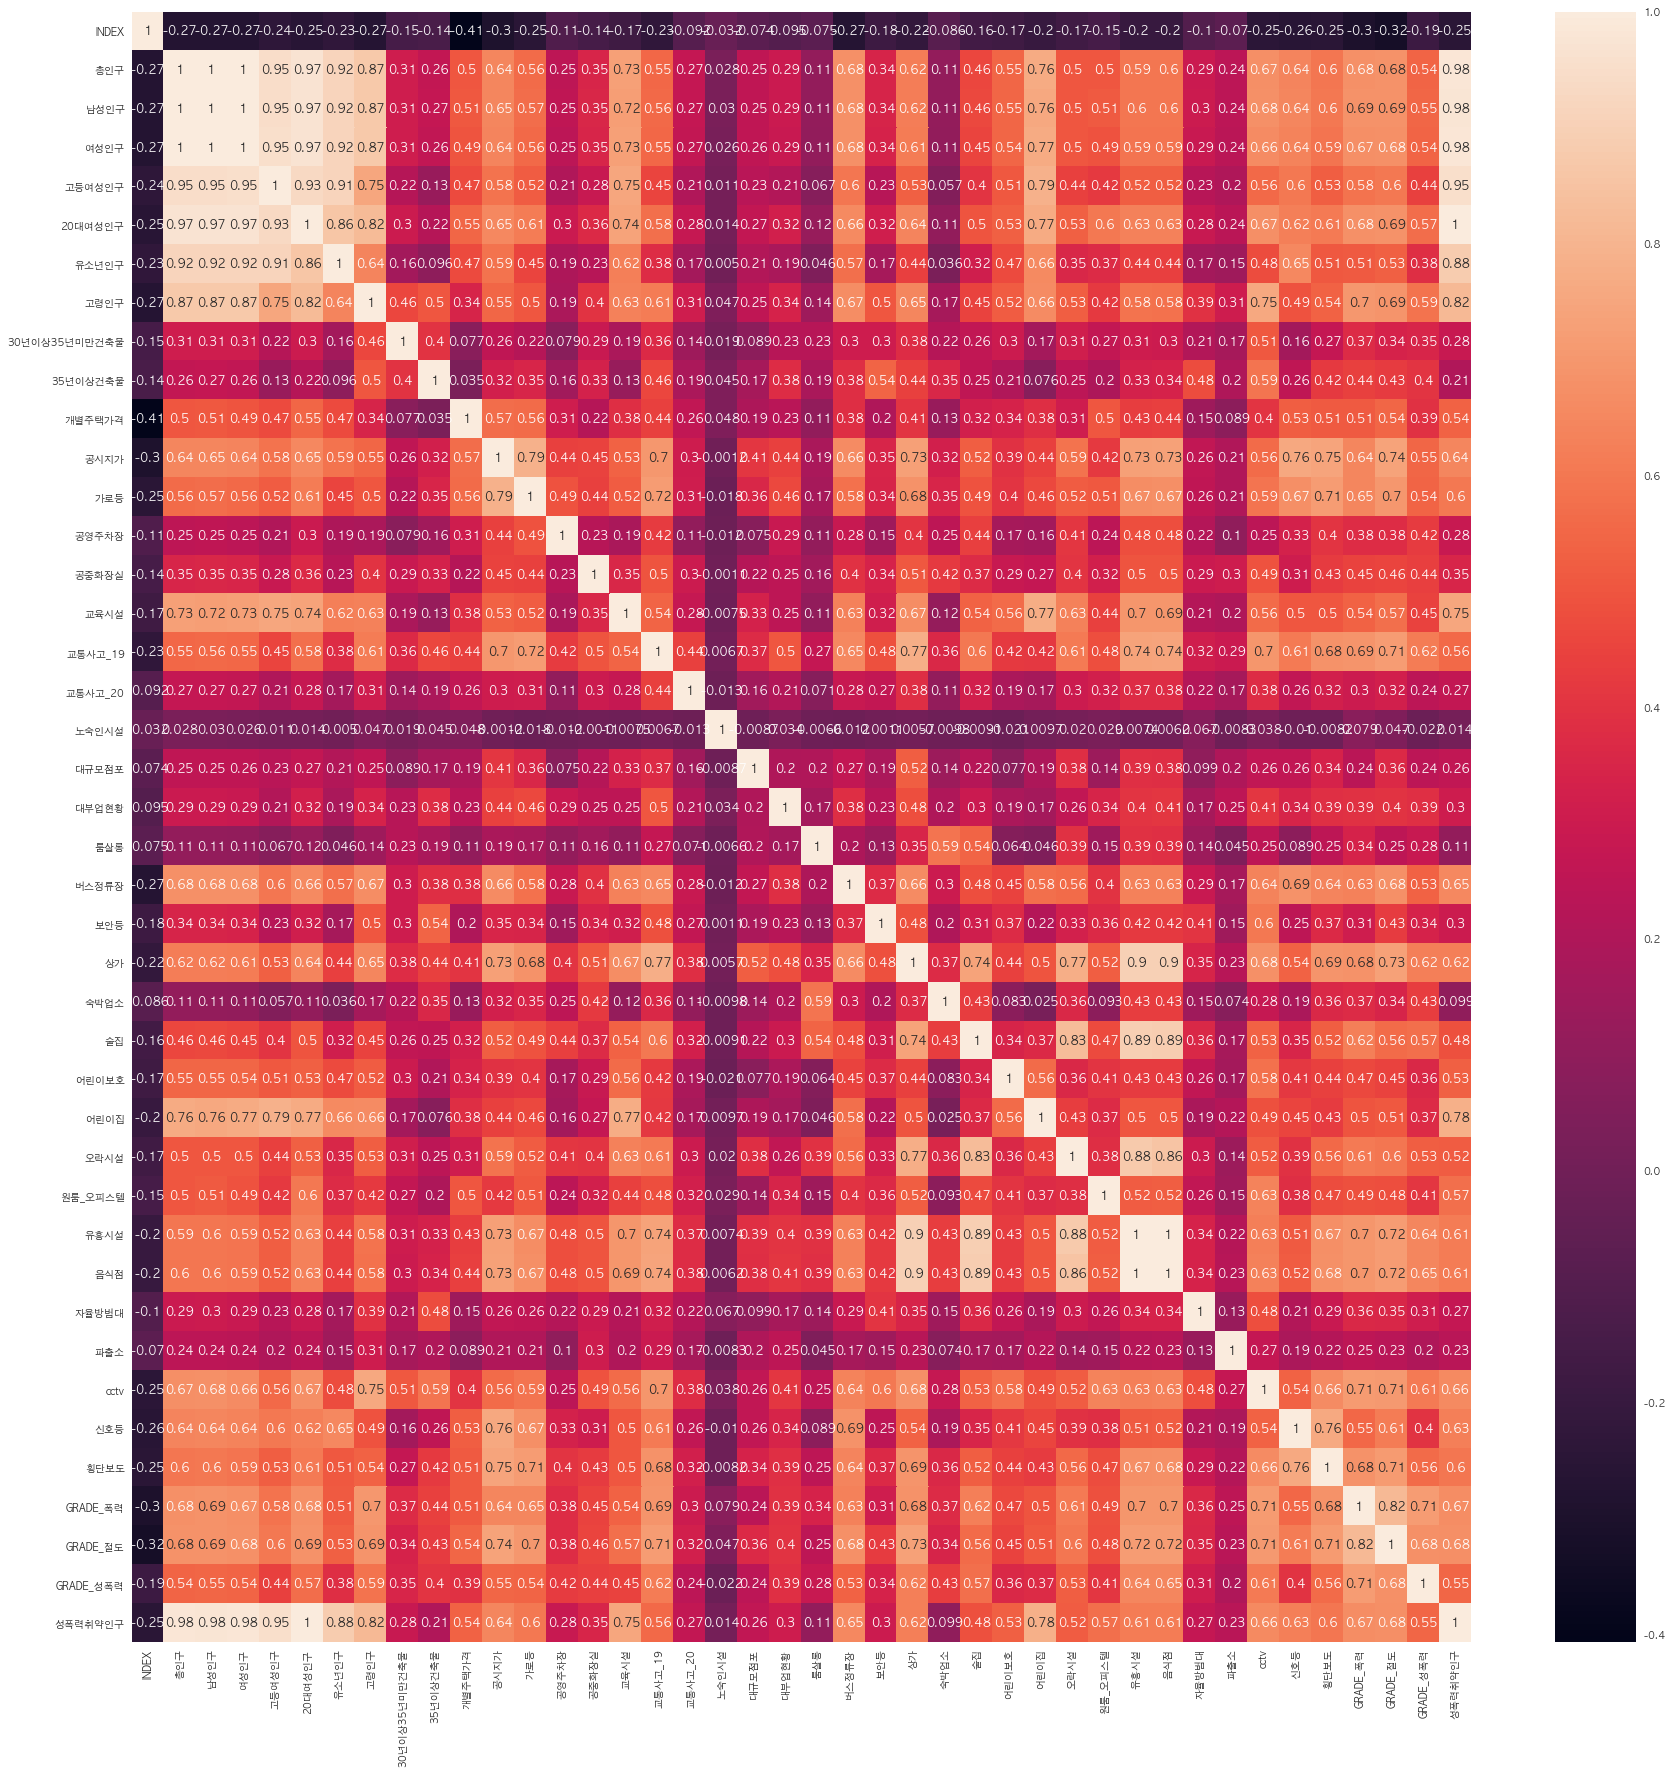

In [79]:
plt.figure(figsize=(30, 30))
sns.heatmap(grid_500.corr(), annot=True)
plt.show()

### 전체 변수 간 상관관계 
 - 인구 사회학적 변수는 변수간 상관관계가 크며, 이는 다중공선성 제거를 위해 변수를 선택할 필요가 있다. 또한, 대부분 범죄 등급과도 큰 상관관계를 보이고 있다. 

#### 종속변수 (3대범죄)를 기반으로 한 상관계수 확인
 - 폭력
     - `인구` : 총인구 (0.68), 남성인구(0.69), 여성인구(0.68), 성폭력취약인구(0.67), 유소년인구(0.51), 고령인구(0.7)
     - `토지` : 30년 이상35년 미만 건축물(0.37), 35년 이상건축물(0.44), 개별주택가격 (0.51), 공시지가(0.64)
     - `시설물` : 가로등(0.65), 공영주차장(0.38), 공중화장실(0.45), 교육시설(0.54), 노숙인시설(0.08), 대규모점포(0.24), 대부업체현황(0.39), 룸살롱(0.34), 버스정류장(0.63), 보안등(0.31), 상가(0.68), 숙박업소(0.37), 술집(0.62), 어린이보호구역(0.47), 어린이집(0.5), 오락시설(0.61), 원룸_오피스텔(0.49), 유흥시설(0.7), 음식점(0.7), 자율방범대(0.36), 파출소(0.25), cctv(0.71), 신호등(0.55), 횡단보도(0.68),
     - `사고` : 교통사고_19(0.69), 교통사고_20(0.3)
     - `다른 범죄` : 절도(0.82), 성폭력(0.71)
 - 절도
     - `인구` : 총인구 (0.68), 남성인구(0.69), 여성인구(0.68), 성폭력취약인구(0.68), 유소년인구(0.53), 고령인구(0.69)
     - `토지` : 30년 이상35년 미만 건축물(0.34), 35년 이상건축물(0.43), 개별주택가격 (0.54), 공시지가(0.74)
     - `시설물` : 가로등(0.7), 공영주차장(0.38), 공중화장실(0.46), 교육시설(0.57), 노숙인시설(0.05), 대규모점포(0.36), 대부업체현황(0.4), 룸살롱(0.25), 버스정류장(0.68), 보안등(0.43), 상가(0.73), 숙박업소(0.34), 술집(0.56), 어린이보호구역(0.45), 어린이집(0.51), 오락시설(0.6), 원룸_오피스텔(0.48), 유흥시설(0.72), 음식점(0.72), 자율방범대(0.35), 파출소(0.23), cctv(0.71), 신호등(0.61), 횡단보도(0.71),
     - `사고` : 교통사고_19(0.71), 교통사고_20(0.32)
     - `다른 범죄` : 폭력(0.82), 성폭력(0.68)
     
 - 성폭력
     - `인구` : 총인구 (0.54), 남성인구(0.55), 여성인구(0.54), 성폭력취약인구(0.55), 유소년인구(0.38), 고령인구(0.59)
     - `토지` : 30년 이상35년 미만 건축물(0.35), 35년 이상건축물(0.4), 개별주택가격 (0.39), 공시지가(0.55)
     - `시설물` : 가로등(0.54), 공영주차장(0.42), 공중화장실(0.44), 교육시설(0.45), 노숙인시설(-0.02), 대규모점포(0.24), 대부업체현황(0.39), 룸살롱(0.28), 버스정류장(0.53), 보안등(0.34), 상가(0.62), 숙박업소(0.43), 술집(0.57), 어린이보호구역(0.36), 어린이집(0.37), 오락시설(0.53), 원룸_오피스텔(0.41), 유흥시설(0.64), 음식점(0.65), 자율방범대(0.31), 파출소(0.2), cctv(0.61), 신호등(0.41), 횡단보도(0.56),
     - `사고` : 교통사고_19(0.62), 교통사고_20(0.24)
     - `다른 범죄` : 절도(0.71), 성폭력(0.68)

### Profile_report


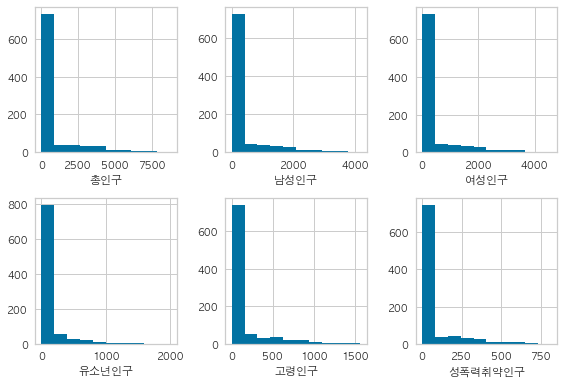

In [80]:
plt.subplot(231)
plt.hist(grid_500['총인구'])
plt.xlabel('총인구')

plt.subplot(232)
plt.hist(grid_500['남성인구'])
plt.xlabel('남성인구')

plt.subplot(233)
plt.hist(grid_500['여성인구'])
plt.xlabel('여성인구')

plt.subplot(234)
plt.hist(grid_500['유소년인구'])
plt.xlabel('유소년인구')

plt.subplot(235)
plt.hist(grid_500['고령인구'])
plt.xlabel('고령인구')

plt.subplot(236)
plt.hist(grid_500['성폭력취약인구'])
plt.xlabel('성폭력취약인구')

plt.tight_layout()
plt.show()

#### 전체적으로 0인 격자가 많고 standard-scale 필요해보임 

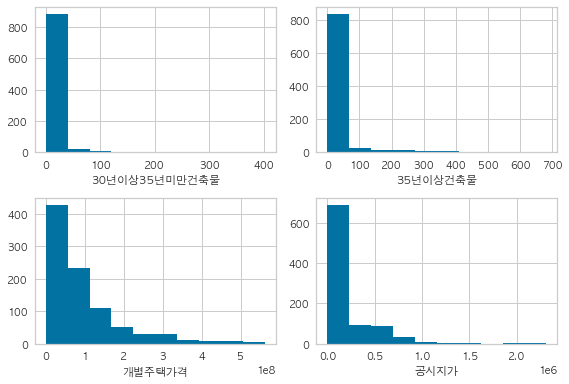

In [81]:
plt.subplot(221)
plt.hist(grid_500['30년이상35년미만건축물'])
plt.xlabel('30년이상35년미만건축물')

plt.subplot(222)
plt.hist(grid_500['35년이상건축물'])
plt.xlabel('35년이상건축물')

plt.subplot(223)
plt.hist(grid_500['개별주택가격'])
plt.xlabel('개별주택가격')

plt.subplot(224)
plt.hist(grid_500['공시지가'])
plt.xlabel('공시지가')

plt.tight_layout()
plt.show()

#### 토지에 관련한 변수를 살펴본 결과에서도 노후 건축물의 경우 데이터의 대부분이 0의 값을 가지고 있음.  
#### 개별주택가격과 공시지가의 경우도 데이터 간 분포차이가 매우 커보임 
#### -> standard-scale 필요

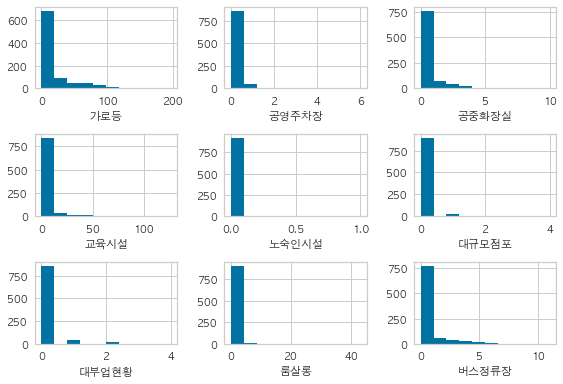

In [82]:
plt.subplot(331)
plt.hist(grid_500['가로등'])
plt.xlabel('가로등')

plt.subplot(332)
plt.hist(grid_500['공영주차장'])
plt.xlabel('공영주차장')

plt.subplot(333)
plt.hist(grid_500['공중화장실'])
plt.xlabel('공중화장실')

plt.subplot(334)
plt.hist(grid_500['교육시설'])
plt.xlabel('교육시설')

plt.subplot(335)
plt.hist(grid_500['노숙인시설'])
plt.xlabel('노숙인시설')

plt.subplot(336)
plt.hist(grid_500['대규모점포'])
plt.xlabel('대규모점포')

plt.subplot(337)
plt.hist(grid_500['대부업현황'])
plt.xlabel('대부업현황')

plt.subplot(338)
plt.hist(grid_500['룸살롱'])
plt.xlabel('룸살롱')

plt.subplot(339)
plt.hist(grid_500['버스정류장'])
plt.xlabel('버스정류장')

plt.tight_layout()
plt.show()

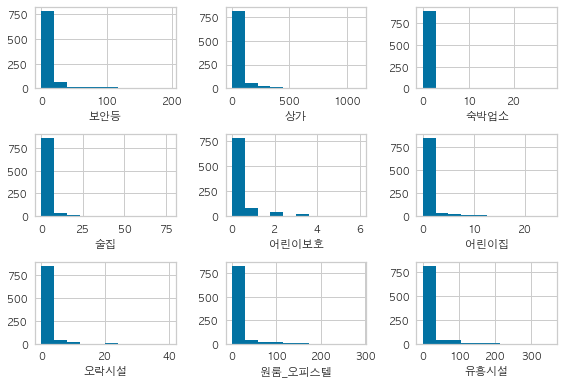

In [83]:
plt.subplot(331)
plt.hist(grid_500['보안등'])
plt.xlabel('보안등')

plt.subplot(332)
plt.hist(grid_500['상가'])
plt.xlabel('상가')

plt.subplot(333)
plt.hist(grid_500['숙박업소'])
plt.xlabel('숙박업소')

plt.subplot(334)
plt.hist(grid_500['술집'])
plt.xlabel('술집')

plt.subplot(335)
plt.hist(grid_500['어린이보호'])
plt.xlabel('어린이보호')

plt.subplot(336)
plt.hist(grid_500['어린이집'])
plt.xlabel('어린이집')

plt.subplot(337)
plt.hist(grid_500['오락시설'])
plt.xlabel('오락시설')

plt.subplot(338)
plt.hist(grid_500['원룸_오피스텔'])
plt.xlabel('원룸_오피스텔')

plt.subplot(339)
plt.hist(grid_500['유흥시설'])
plt.xlabel('유흥시설')

plt.tight_layout()
plt.show()

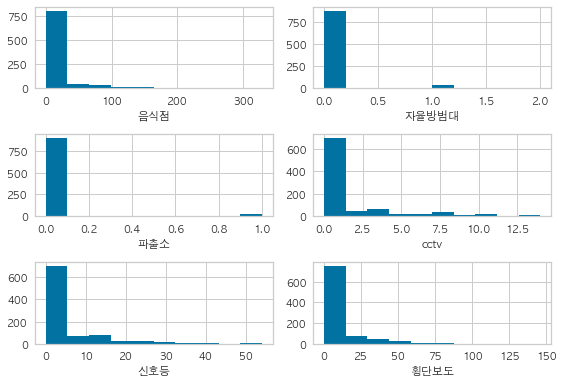

In [84]:
plt.subplot(321)
plt.hist(grid_500['음식점'])
plt.xlabel('음식점')

plt.subplot(322)
plt.hist(grid_500['자율방범대'])
plt.xlabel('자율방범대')

plt.subplot(323)
plt.hist(grid_500['파출소'])
plt.xlabel('파출소')

plt.subplot(324)
plt.hist(grid_500['cctv'])
plt.xlabel('cctv')

plt.subplot(325)
plt.hist(grid_500['신호등'])
plt.xlabel('신호등')

plt.subplot(326)
plt.hist(grid_500['횡단보도'])
plt.xlabel('횡단보도')

plt.tight_layout()
plt.show()

#### 공간적 변수도 대부분 0인 격자가 대부분이며 표준화 작업이 필수일듯 

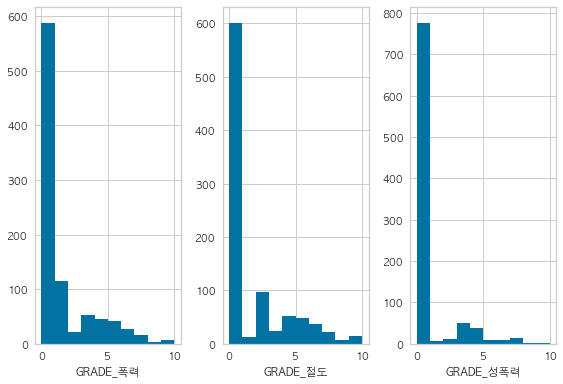

In [85]:
plt.subplot(131)
plt.hist(grid_500['GRADE_폭력'])
plt.xlabel('GRADE_폭력')

plt.subplot(132)
plt.hist(grid_500['GRADE_절도'])
plt.xlabel('GRADE_절도')

plt.subplot(133)
plt.hist(grid_500['GRADE_성폭력'])
plt.xlabel('GRADE_성폭력')

plt.tight_layout()
plt.show()

In [86]:
len(grid_500)

918

In [87]:
len(grid_500[grid_500['GRADE_폭력']>0])

330

In [88]:
len(grid_500[grid_500['GRADE_절도']>0])

317

In [89]:
len(grid_500[grid_500['GRADE_성폭력']>0])

142

- 918개의 격자 중 범죄주의구간의 등급이 0보다 큰 곳은 각 범죄별로 폭력 330, 절도 317, 성폭력 142이다. 
     - 이를 어떻게 해석하고 이용해야할까? 
     - 빼고 t-test ..?

In [90]:
grid_500.dtypes

INDEX              int64
ID                object
총인구                int64
남성인구               int64
여성인구               int64
고등여성인구             int64
20대여성인구            int64
유소년인구              int64
고령인구               int64
30년이상35년미만건축물      int64
35년이상건축물           int64
개별주택가격           float64
공시지가             float64
행정동코드             object
가로등                int64
공영주차장              int64
공중화장실              int64
교육시설               int64
교통사고_19            int64
교통사고_20            int64
노숙인시설              int64
대규모점포              int64
대부업현황              int64
룸살롱                int64
버스정류장              int64
보안등                int64
상가                 int64
숙박업소               int64
술집                 int64
어린이보호              int64
어린이집               int64
오락시설               int64
원룸_오피스텔            int64
유흥시설               int64
음식점                int64
자율방범대              int64
파출소                int64
cctv               int64
신호등                int64
횡단보도               int64


In [91]:
len(grid_500.columns)

44

#### 분석에 이용할 numeric 변수에 대해 다중공선성 확인 및 정규화 준비를 위해 변수 구분

In [92]:
numerical_feats = grid_500.dtypes[grid_500.dtypes != "object"].index.tolist()
numerical_feats.remove('INDEX')
numerical_feats.remove('GRADE_폭력')
numerical_feats.remove('GRADE_절도')
numerical_feats.remove('GRADE_성폭력')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = grid_500.dtypes[grid_500.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  38
Number of Categorical features:  2


In [93]:
grid_500.columns

Index(['INDEX', 'ID', '총인구', '남성인구', '여성인구', '고등여성인구', '20대여성인구', '유소년인구',
       '고령인구', '30년이상35년미만건축물', '35년이상건축물', '개별주택가격', '공시지가', '행정동코드', '가로등',
       '공영주차장', '공중화장실', '교육시설', '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포',
       '대부업현황', '룸살롱', '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집',
       '오락시설', '원룸_오피스텔', '유흥시설', '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도',
       'GRADE_폭력', 'GRADE_절도', 'GRADE_성폭력', '성폭력취약인구'],
      dtype='object')

### 다중회귀분석 target <- GRADE_폭력

In [94]:
# 다중 선형회귀분석
x_data = grid_500[['총인구', '남성인구', '여성인구', '고등여성인구', '20대여성인구', '유소년인구',
       '고령인구', '30년이상35년미만건축물', '35년이상건축물', '개별주택가격', '공시지가', '가로등',
       '공영주차장', '공중화장실', '교육시설', '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포',
       '대부업현황', '룸살롱', '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집',
       '오락시설', '원룸_오피스텔', '유흥시설', '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도',
       '성폭력취약인구']] #변수 여러개
target = grid_500[["GRADE_폭력"]]

# for b0, 상수항 추가
x_data1 = sm.add_constant(x_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(target, x_data1)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               GRADE_폭력   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     81.29
Date:                Wed, 18 Aug 2021   Prob (F-statistic):          3.92e-252
Time:                        15:38:31   Log-Likelihood:                -1285.5
No. Observations:                 918   AIC:                             2645.
Df Residuals:                     881   BIC:                             2823.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0594      0.047      1.258      0.209      -0.033       0.152
총인구              -0.0143      0.023     -0.624      0.533      -0.059       0.031
남성인구              0.0199      0.023      0.874      0.383      -0.025       0.065
여성인구              0.0114      0.023      0.499      0.618      -0.033       0.056
고등여성인구           -0.0030      0.004     -0.789      0.430      -0.010       0.004
20대여성인구          -0.0015      0.002     -0.652      0.514      -0.006       0.003
유소년인구            -0.0036      0.001     -2.610      0.009      -0.006      -0.001
고령인구              0.0008      0.001      0.772      0.440      -0.001       0.003
30년이상35년미만건축물    -0.0013      0.002     -0.680      0.496      -0.005       0.002
35년이상건축물          0.0022      0.001      2.685      0.007       0.001       0.004
개별주택가격         3.158e-09   4.52e-10      6.983      0.000    2.27e-09    4.05e-09
공시지가           2.946e-07   2.71e-07      1.088      0.277   -2.37e-07    8.26e-07
가로등               0.0073      0.002      3.237      0.001       0.003       0.012
공영주차장             0.1018      0.108      0.944      0.346      -0.110       0.314
공중화장실             0.0630      0.043      1.459      0.145      -0.022       0.148
교육시설              0.0017      0.006      0.273      0.785      -0.010       0.014
교통사고_19           0.0360      0.012      3.116      0.002       0.013       0.059
교통사고_20          -0.0099      0.004     -2.338      0.020      -0.018      -0.002
노숙인시설             1.3436      0.596      2.253      0.025       0.173       2.514
대규모점포            -0.3317      0.172     -1.926      0.054      -0.670       0.006
대부업현황            -0.0483      0.107     -0.452      0.651      -0.258       0.161
룸살롱               0.0609      0.020      3.028      0.003       0.021       0.100
버스정류장             0.0442      0.046      0.968      0.333      -0.045       0.134
보안등              -0.0171      0.002     -9.511      0.000      -0.021      -0.014
상가               -0.0004      0.001     -0.381      0.703      -0.003       0.002
숙박업소              0.0028      0.020      0.141      0.888      -0.036       0.041
술집                0.0599      0.020      3.003      0.003       0.021       0.099
어린이보호             0.1059      0.067      1.576      0.115      -0.026       0.238
어린이집             -0.0267      0.035     -0.760      0.448      -0.096       0.042
오락시설              0.0211      0.017      1.262      0.207      -0.012       0.054
원룸_오피스텔          -0.0040      0.002     -1.910      0.057      -0.008       0.000
유흥시설              0.0089      0.008      1.093      0.275      -0.007       0.025
음식점              -0.0122      0.009     -1.328      0.185      -0.030       0.006
자율방범대            -0.0749      0.177     -0.423      0.672      -0.423       0.273
파출소               0.0349      0.270      0.129   

#### 분석 결과
 - 변수간 다중공선성이 강해보임 
 - 유의한 회귀계수를 가지는 변수 (유의수준 0.05 이하 & 0.1 미만)
     - 유소년인구 (0.009), 35년이상건축물(0.007), 개별주택가격(0.000), 가로등(0.001), 교통사고_19(0.002), 교통사고_20(0.02), 노숙인시설(0.025), 대규모점포(0.054)
     - 룸살롱(0.003), 보안등(0.000), 술집(0.003), 원룸_오피스텔(0.057), cctv(0.000), 신호등(0.025), 횡단보도(0.000), 성폭력취약인구(0.056)

In [95]:
#다중공선성확인
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(grid_500[numerical_feats].values, i) for i in range(grid_500[numerical_feats].shape[1])]
vif["features"] = grid_500[numerical_feats].columns 
vif

,VIF Factor,features
0,1.315927e+06,총인구
1,3.131583e+05,남성인구
2,3.472137e+05,여성인구
3,inf,고등여성인구
4,inf,20대여성인구
5,8.992189e+01,유소년인구
6,9.149238e+01,고령인구
7,1.789024e+00,30년이상35년미만건축물
8,3.859145e+00,35년이상건축물
9,2.928657e+00,개별주택가격


### 다중공선성에 크게 영향을 미치는 변수 제거 후 재분석

In [96]:
# 다중 선형회귀분석
x_data = grid_500[['유소년인구','고령인구', '30년이상35년미만건축물', '35년이상건축물', '개별주택가격', '공시지가', '가로등',
       '공영주차장', '공중화장실', '교육시설', '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포',
       '대부업현황', '룸살롱', '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집',
       '오락시설', '원룸_오피스텔', '유흥시설', '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도',
       '성폭력취약인구']] #변수 여러개
target = grid_500[["GRADE_폭력"]]

# for b0, 상수항 추가
x_data1 = sm.add_constant(x_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(target, x_data1)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               GRADE_폭력   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     86.27
Date:                Wed, 18 Aug 2021   Prob (F-statistic):          6.63e-247
Time:                        15:38:32   Log-Likelihood:                -1307.6
No. Observations:                 918   AIC:                             2681.
Df Residuals:                     885   BIC:                             2840.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0716      0.047      1.512      0.131      -0.021       0.165
유소년인구             0.0002      0.000      0.495      0.621      -0.001       0.001
고령인구              0.0030      0.000      7.884      0.000       0.002       0.004
30년이상35년미만건축물    -0.0023      0.002     -1.244      0.214      -0.006       0.001
35년이상건축물          0.0023      0.001      2.953      0.003       0.001       0.004
개별주택가격         3.385e-09   4.58e-10      7.391      0.000    2.49e-09    4.28e-09
공시지가           2.139e-07   2.76e-07      0.775      0.439   -3.28e-07    7.55e-07
가로등               0.0067      0.002      2.943      0.003       0.002       0.011
공영주차장             0.1194      0.109      1.093      0.275      -0.095       0.334
공중화장실             0.0631      0.044      1.436      0.151      -0.023       0.149
교육시설             -0.0029      0.006     -0.484      0.629      -0.015       0.009
교통사고_19           0.0404      0.012      3.439      0.001       0.017       0.064
교통사고_20          -0.0099      0.004     -2.275      0.023      -0.018      -0.001
노숙인시설             1.7402      0.603      2.885      0.004       0.556       2.924
대규모점포            -0.4785      0.174     -2.747      0.006      -0.820      -0.137
대부업현황            -0.1115      0.108     -1.028      0.304      -0.324       0.101
룸살롱               0.0614      0.020      2.998      0.003       0.021       0.102
버스정류장             0.0671      0.046      1.452      0.147      -0.024       0.158
보안등              -0.0186      0.002    -10.436      0.000      -0.022      -0.015
상가                0.0002      0.001      0.191      0.848      -0.002       0.003
숙박업소              0.0078      0.020      0.392      0.695      -0.031       0.047
술집                0.0573      0.020      2.834      0.005       0.018       0.097
어린이보호             0.1130      0.068      1.657      0.098      -0.021       0.247
어린이집             -0.0441      0.035     -1.278      0.202      -0.112       0.024
오락시설              0.0093      0.017      0.551      0.582      -0.024       0.042
원룸_오피스텔          -0.0007      0.002     -0.368      0.713      -0.004       0.003
유흥시설              0.0041      0.008      0.503      0.615      -0.012       0.020
음식점              -0.0051      0.009     -0.556      0.578      -0.023       0.013
자율방범대             0.0253      0.178      0.142      0.887      -0.325       0.376
파출소               0.1591      0.272      0.584      0.559      -0.376       0.694
cctv              0.1262      0.030      4.273      0.000       0.068       0.184
신호등              -0.0240      0.009     -2.710      0.007      -0.041      -0.007
횡단보도              0.0201      0.005      4.421      0.000       0.011       0.029
성폭력취약인구          -0.0008      0.001     -0.713      0.476      -0.003       0.001
=================================================

### 유의한 회귀계수를 가지는 변수로 분석

In [97]:
# 다중 선형회귀분석
x_data = grid_500[['고령인구',  '35년이상건축물', '개별주택가격', '가로등',
         '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포',
        '룸살롱',  '보안등',  '술집', 
        'cctv', '신호등', '횡단보도',
       '성폭력취약인구']] #변수 여러개
target = grid_500[["GRADE_폭력"]]

# for b0, 상수항 추가
x_data1 = sm.add_constant(x_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(target, x_data1)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               GRADE_폭력   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     182.9
Date:                Wed, 18 Aug 2021   Prob (F-statistic):          4.16e-261
Time:                        15:38:32   Log-Likelihood:                -1316.2
No. Observations:                 918   AIC:                             2664.
Df Residuals:                     902   BIC:                             2742.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0875      0.046      1.915      0.056      -0.002       0.177
고령인구           0.0030      0.000      9.602      0.000       0.002       0.004
35년이상건축물       0.0024      0.001      3.551      0.000       0.001       0.004
개별주택가격      3.433e-09   4.34e-10      7.908      0.000    2.58e-09    4.29e-09
가로등            0.0075      0.002      3.831      0.000       0.004       0.011
교통사고_19        0.0426      0.011      3.928      0.000       0.021       0.064
교통사고_20       -0.0103      0.004     -2.428      0.015      -0.019      -0.002
노숙인시설          1.6509      0.597      2.763      0.006       0.478       2.823
대규모점포         -0.4572      0.137     -3.326      0.001      -0.727      -0.187
룸살롱            0.0588      0.016      3.604      0.000       0.027       0.091
보안등           -0.0179      0.002    -10.644      0.000      -0.021      -0.015
술집             0.0667      0.010      6.986      0.000       0.048       0.085
cctv           0.1199      0.024      5.000      0.000       0.073       0.167
신호등           -0.0149      0.007     -2.059      0.040      -0.029      -0.001
횡단보도           0.0224      0.004      5.154      0.000       0.014       0.031
성폭력취약인구       -0.0010      0.001     -1.557      0.120      -0.002       0.000
==============================================================================
Omnibus:                      308.612   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1409.622
Skew:                           1.499   Prob(JB):                    8.03e-307
Kurtosis:                       8.279   Cond. No.                     2.43e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.43e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

메모:  
[1] 표준 오차는 오차의 공분산 행렬이 올바르게 지정되었다고 가정합니다.  
[2] 조건 번호가 2.43e+09로 큽니다. 이것은 다음이 있음을 나타낼 수 있습니다.  
강한 다중공선성 또는 기타 수치 문제.

### Stepwise

In [98]:
# 변수선택을 통해 형성한 모델의 AIC를 구하는 함수
# AIC가 낮을 수록 모델이 좋다고 평가된다.
# 다중 선형회귀분석
x_data = grid_500[['총인구', '남성인구', '여성인구', '고등여성인구', '20대여성인구', '유소년인구',
       '고령인구', '30년이상35년미만건축물', '35년이상건축물', '개별주택가격', '공시지가', '가로등',
       '공영주차장', '공중화장실', '교육시설', '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포',
       '대부업현황', '룸살롱', '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집',
       '오락시설', '원룸_오피스텔', '유흥시설', '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도',
       '성폭력취약인구']] #변수 여러개
target = grid_500[["GRADE_폭력"]]

x_data1 = sm.add_constant(x_data, has_constant = "add")


def processSubset(X,y):
    model = sm.OLS(y,X) # Modeling
    regr = model.fit() # model fitting
    AIC = regr.aic # model's AIC
    return {"model" : regr, "AIC" : AIC}
    
processSubset(X = x_data1, y = target)

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7ff277a5f220>,
 'AIC': 2645.0712390076487}

## 전진 선택법

In [99]:
x_data = grid_500[['총인구', '남성인구', '여성인구', '고등여성인구', '20대여성인구', '유소년인구',
       '고령인구', '30년이상35년미만건축물', '35년이상건축물', '개별주택가격', '공시지가', '가로등',
       '공영주차장', '공중화장실', '교육시설', '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포',
       '대부업현황', '룸살롱', '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집',
       '오락시설', '원룸_오피스텔', '유흥시설', '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도',
       '성폭력취약인구']] #변수 여러개

target = grid_500[["GRADE_폭력"]]

selected_variables = [] ## 선택된 변수들

sl_enter = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(x_data) > 0:
    remainder = list(set(x_data) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = x_data[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(target,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(target,sm.add_constant(x_data[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [100]:
selected_variables

['cctv',
 '유흥시설',
 '남성인구',
 '보안등',
 '35년이상건축물',
 '개별주택가격',
 '유소년인구',
 '성폭력취약인구',
 '룸살롱',
 '가로등',
 '횡단보도',
 '술집',
 '교통사고_19',
 '교통사고_20',
 '대규모점포',
 '신호등',
 '노숙인시설']

In [101]:
# 다중 선형회귀분석
x_data = grid_500[selected_variables]
target = grid_500[["GRADE_폭력"]]

# for b0, 상수항 추가
x_data1 = sm.add_constant(x_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(target, x_data1)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               GRADE_폭력   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     170.3
Date:                Wed, 18 Aug 2021   Prob (F-statistic):          4.70e-267
Time:                        15:38:35   Log-Likelihood:                -1296.9
No. Observations:                 918   AIC:                             2630.
Df Residuals:                     900   BIC:                             2717.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0762      0.045      1.695      0.090      -0.012       0.164
cctv           0.1117      0.024      4.628      0.000       0.064       0.159
유흥시설           0.0004      0.003      0.142      0.887      -0.006       0.006
남성인구           0.0038      0.000     11.487      0.000       0.003       0.004
보안등           -0.0182      0.002    -10.888      0.000      -0.021      -0.015
35년이상건축물       0.0025      0.001      3.829      0.000       0.001       0.004
개별주택가격      3.187e-09   4.22e-10      7.553      0.000    2.36e-09    4.02e-09
유소년인구         -0.0043      0.001     -7.917      0.000      -0.005      -0.003
성폭력취약인구       -0.0108      0.001     -7.380      0.000      -0.014      -0.008
룸살롱            0.0585      0.017      3.537      0.000       0.026       0.091
가로등            0.0087      0.002      4.280      0.000       0.005       0.013
횡단보도           0.0198      0.004      4.587      0.000       0.011       0.028
술집             0.0605      0.017      3.505      0.000       0.027       0.094
교통사고_19        0.0411      0.011      3.757      0.000       0.020       0.063
교통사고_20       -0.0109      0.004     -2.637      0.009      -0.019      -0.003
대규모점포         -0.3423      0.144     -2.384      0.017      -0.624      -0.061
신호등           -0.0163      0.008     -2.071      0.039      -0.032      -0.001
노숙인시설          1.2136      0.589      2.061      0.040       0.058       2.369
==============================================================================
Omnibus:                      327.129   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1549.635
Skew:                           1.587   Prob(JB):                         0.00
Kurtosis:                       8.518   Cond. No.                     2.44e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

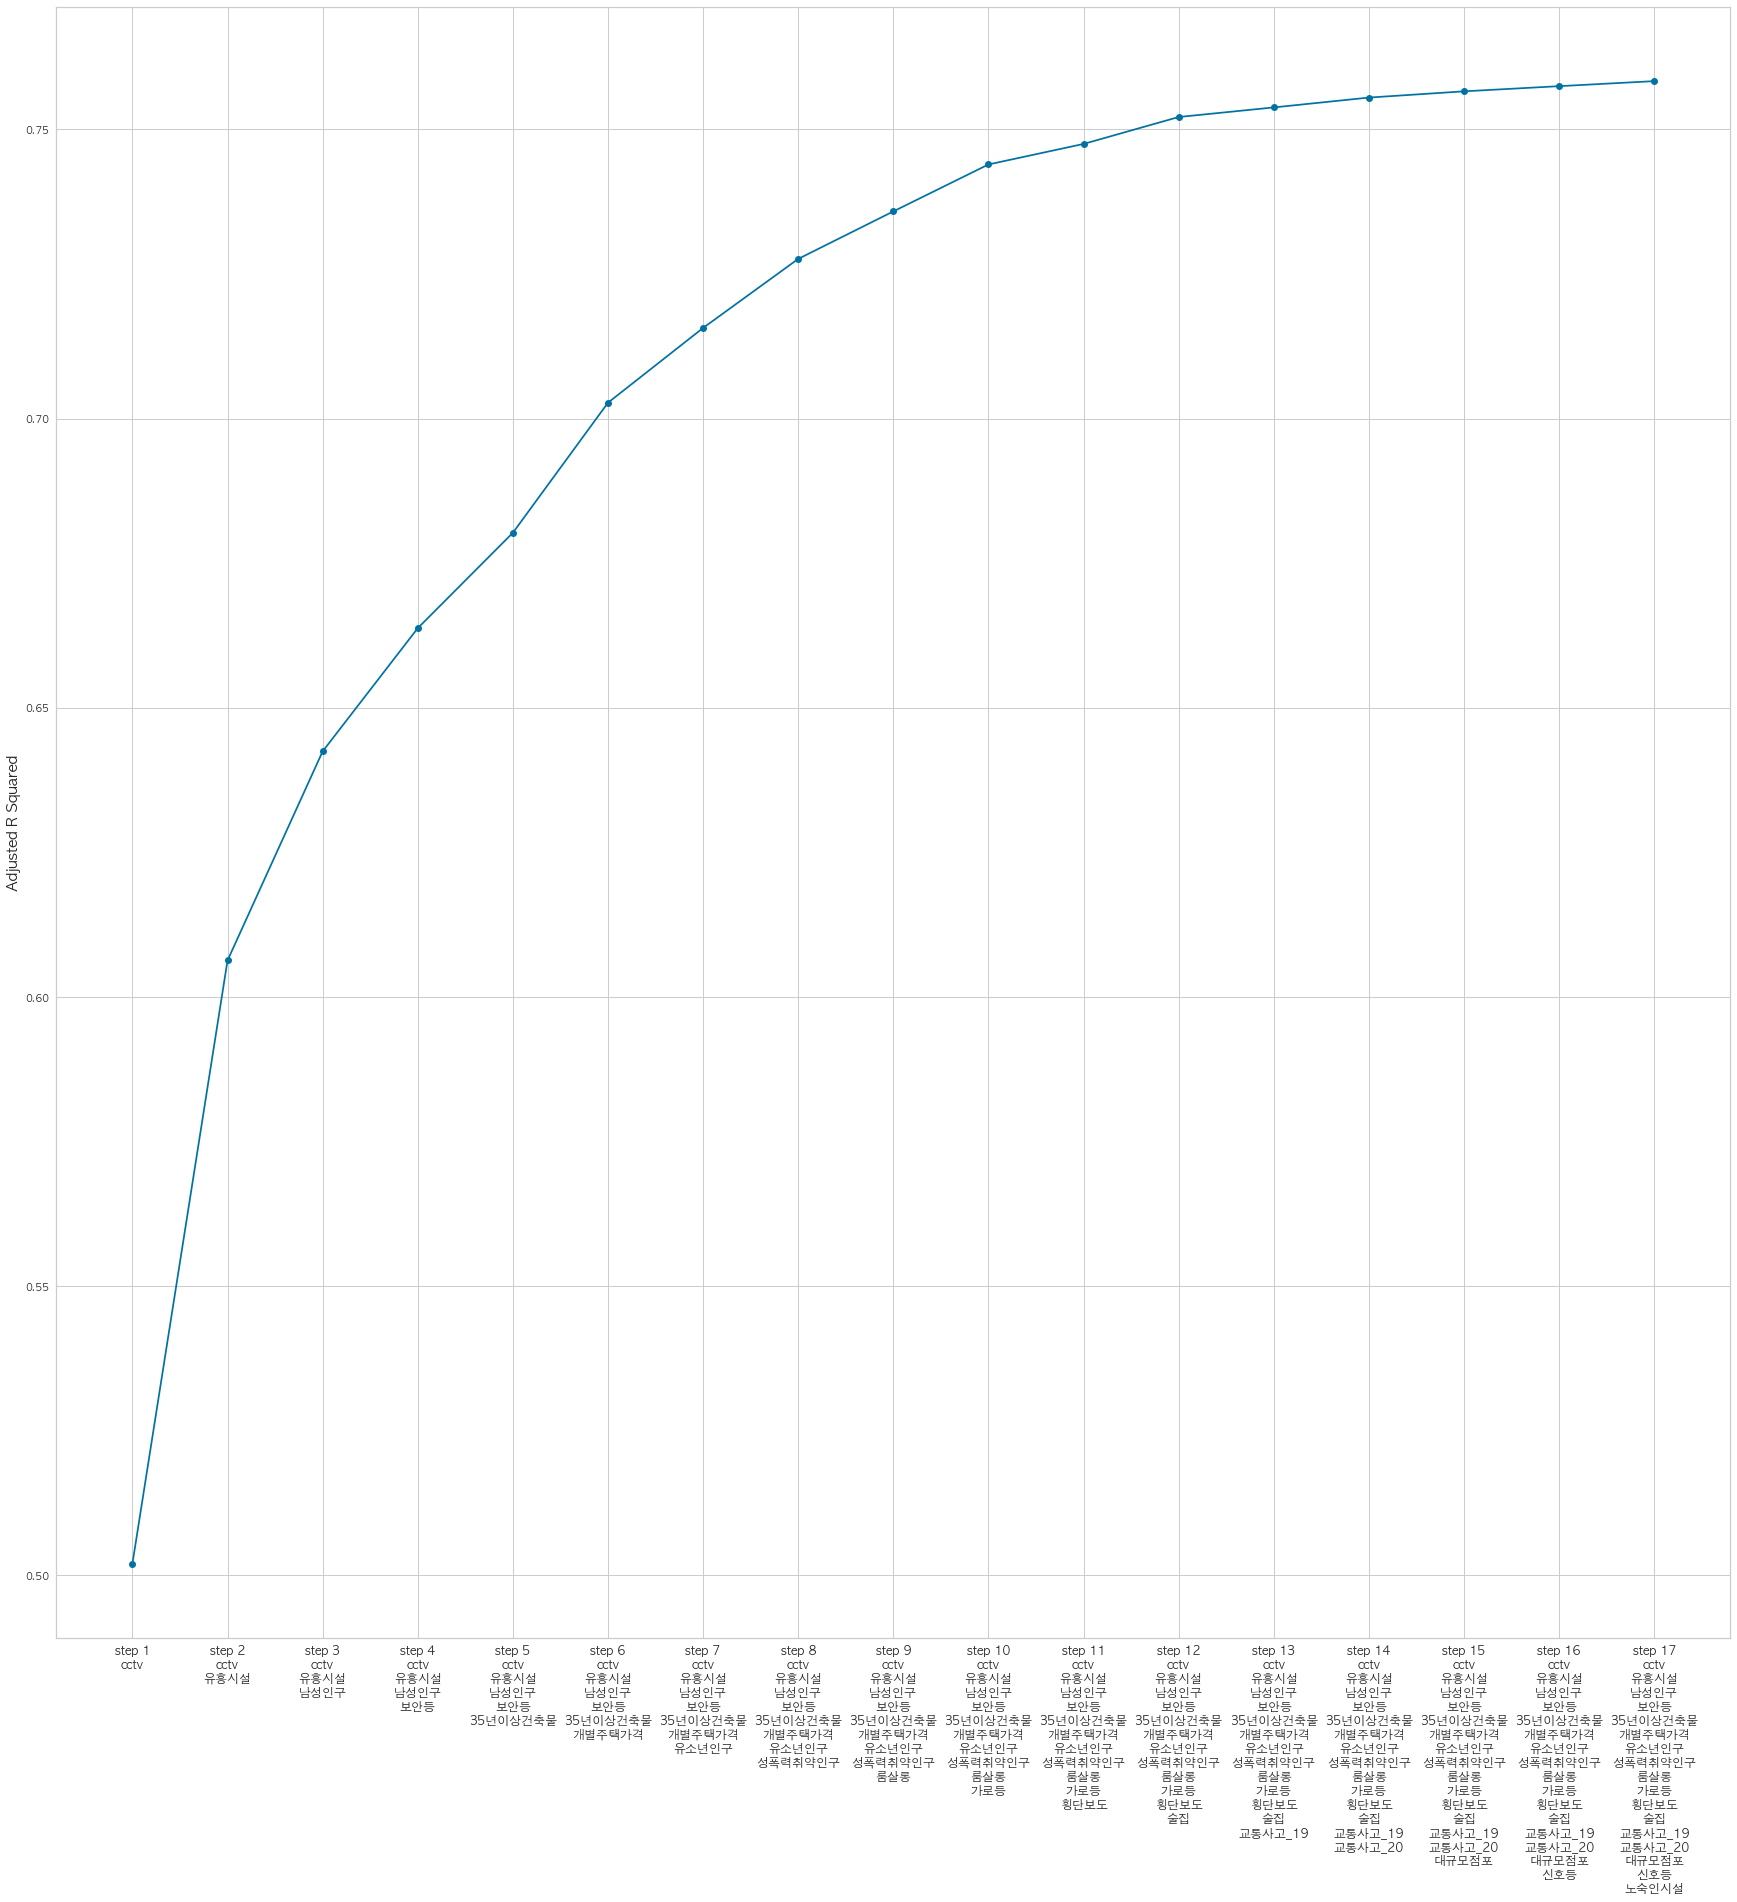

In [102]:
fig = plt.figure(figsize=(30,30))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

## 후진소거법

In [103]:
## 후진 소거법
x_data = grid_500[['총인구', '남성인구', '여성인구', '고등여성인구', '20대여성인구', '유소년인구',
       '고령인구', '30년이상35년미만건축물', '35년이상건축물', '개별주택가격', '공시지가', '가로등',
       '공영주차장', '공중화장실', '교육시설', '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포',
       '대부업현황', '룸살롱', '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집',
       '오락시설', '원룸_오피스텔', '유흥시설', '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도',
       '성폭력취약인구']] #변수 여러개

target = grid_500[["GRADE_폭력"]]

selected_variables = x_data.columns.tolist()

sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(selected_variables) > 0:
    X = sm.add_constant(grid_500[selected_variables])
    p_vals = sm.OLS(target,X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
    max_pval = p_vals.max() ## 최대 p-value
    if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
        remove_variable = p_vals.idxmax()
        selected_variables.remove(remove_variable)
 
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(target,sm.add_constant(x_data[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [104]:
selected_variables

['총인구',
 '남성인구',
 '유소년인구',
 '35년이상건축물',
 '개별주택가격',
 '가로등',
 '교통사고_19',
 '교통사고_20',
 '노숙인시설',
 '대규모점포',
 '룸살롱',
 '보안등',
 '술집',
 '원룸_오피스텔',
 'cctv',
 '신호등',
 '횡단보도',
 '성폭력취약인구']

In [105]:
# 다중 선형회귀분석
x_data = grid_500[selected_variables]
target = grid_500[["GRADE_폭력"]]

# for b0, 상수항 추가
x_data1 = sm.add_constant(x_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(target, x_data1)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               GRADE_폭력   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     162.6
Date:                Wed, 18 Aug 2021   Prob (F-statistic):          1.01e-267
Time:                        15:38:38   Log-Likelihood:                -1292.6
No. Observations:                 918   AIC:                             2623.
Df Residuals:                     899   BIC:                             2715.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0687      0.045      1.524      0.128      -0.020       0.157
총인구           -0.0021      0.001     -2.507      0.012      -0.004      -0.000
남성인구           0.0079      0.002      4.668      0.000       0.005       0.011
유소년인구         -0.0044      0.001     -8.250      0.000      -0.005      -0.003
35년이상건축물       0.0021      0.001      3.223      0.001       0.001       0.003
개별주택가격      3.188e-09   4.33e-10      7.364      0.000    2.34e-09    4.04e-09
가로등            0.0086      0.002      4.358      0.000       0.005       0.012
교통사고_19        0.0400      0.011      3.721      0.000       0.019       0.061
교통사고_20       -0.0104      0.004     -2.505      0.012      -0.018      -0.002
노숙인시설          1.2252      0.586      2.090      0.037       0.075       2.376
대규모점포         -0.3312      0.136     -2.439      0.015      -0.598      -0.065
룸살롱            0.0559      0.016      3.499      0.000       0.025       0.087
보안등           -0.0168      0.002     -9.902      0.000      -0.020      -0.014
술집             0.0630      0.009      6.719      0.000       0.045       0.081
원룸_오피스텔       -0.0046      0.002     -2.423      0.016      -0.008      -0.001
cctv           0.1230      0.026      4.808      0.000       0.073       0.173
신호등           -0.0156      0.008     -1.985      0.047      -0.031      -0.000
횡단보도           0.0198      0.004      4.677      0.000       0.011       0.028
성폭력취약인구       -0.0085      0.002     -5.140      0.000      -0.012      -0.005
==============================================================================
Omnibus:                      323.991   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1494.525
Skew:                           1.580   Prob(JB):                         0.00
Kurtosis:                       8.394   Cond. No.                     2.44e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

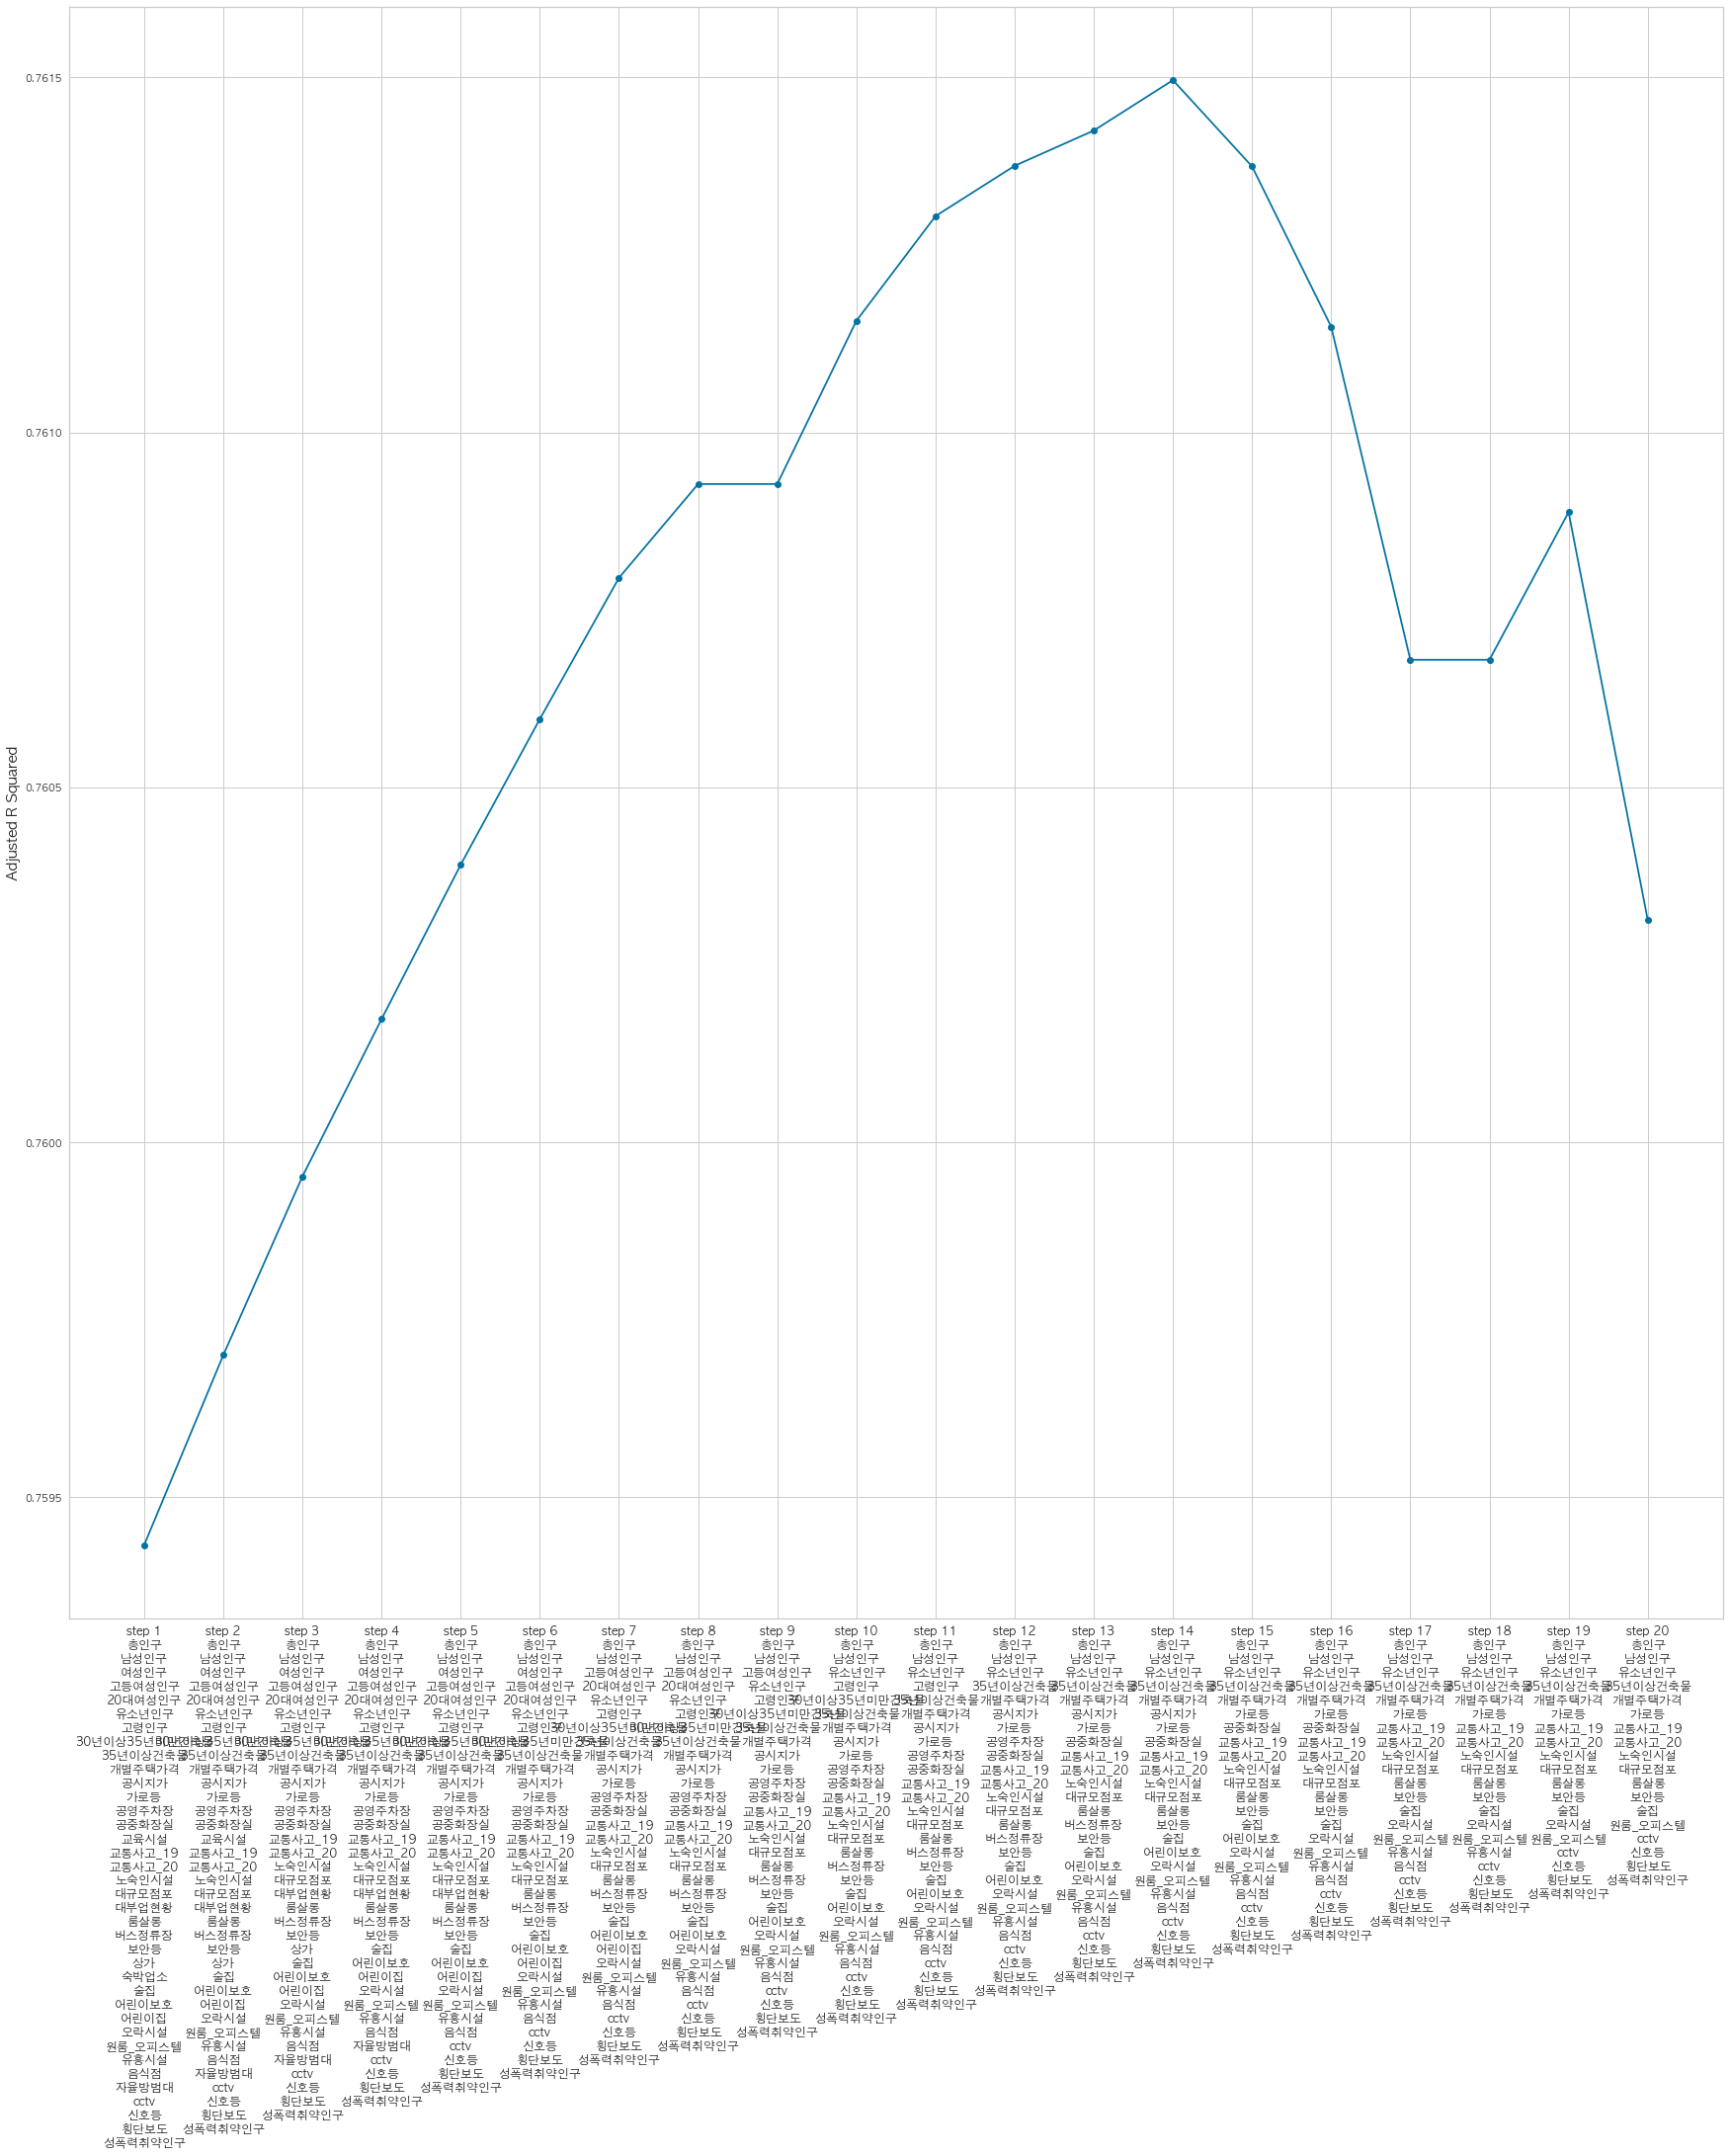

In [106]:
fig = plt.figure(figsize=(30,30))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

In [107]:
## 전진 단계별 선택법
x_data = grid_500[['총인구', '남성인구', '여성인구', '고등여성인구', '20대여성인구', '유소년인구',
       '고령인구', '30년이상35년미만건축물', '35년이상건축물', '개별주택가격', '공시지가', '가로등',
       '공영주차장', '공중화장실', '교육시설', '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포',
       '대부업현황', '룸살롱', '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집',
       '오락시설', '원룸_오피스텔', '유흥시설', '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도',
       '성폭력취약인구']] #변수 여러개
variables = x_data.columns.tolist() ## 설명 변수 리스트
 
y = grid_500['GRADE_폭력'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = grid_500[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(target,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = grid_500[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(target,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(target,sm.add_constant(grid_500[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [108]:
selected_variables

['cctv',
 '남성인구',
 '보안등',
 '35년이상건축물',
 '개별주택가격',
 '유소년인구',
 '성폭력취약인구',
 '룸살롱',
 '가로등',
 '횡단보도',
 '술집',
 '교통사고_19',
 '교통사고_20',
 '대규모점포',
 '신호등',
 '노숙인시설']

In [109]:
# 다중 선형회귀분석
x_data = grid_500[selected_variables]
target = grid_500[["GRADE_폭력"]]

# for b0, 상수항 추가
x_data1 = sm.add_constant(x_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(target, x_data1)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               GRADE_폭력   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     181.1
Date:                Wed, 18 Aug 2021   Prob (F-statistic):          3.47e-268
Time:                        15:38:44   Log-Likelihood:                -1296.9
No. Observations:                 918   AIC:                             2628.
Df Residuals:                     901   BIC:                             2710.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0758      0.045      1.691      0.091      -0.012       0.164
cctv           0.1111      0.024      4.669      0.000       0.064       0.158
남성인구           0.0038      0.000     11.610      0.000       0.003       0.004
보안등           -0.0181      0.002    -11.013      0.000      -0.021      -0.015
35년이상건축물       0.0025      0.001      3.829      0.000       0.001       0.004
개별주택가격      3.187e-09   4.22e-10      7.556      0.000    2.36e-09    4.01e-09
유소년인구         -0.0043      0.001     -8.002      0.000      -0.005      -0.003
성폭력취약인구       -0.0108      0.001     -7.395      0.000      -0.014      -0.008
룸살롱            0.0579      0.016      3.615      0.000       0.026       0.089
가로등            0.0087      0.002      4.402      0.000       0.005       0.013
횡단보도           0.0199      0.004      4.697      0.000       0.012       0.028
술집             0.0625      0.009      6.686      0.000       0.044       0.081
교통사고_19        0.0414      0.011      3.849      0.000       0.020       0.063
교통사고_20       -0.0109      0.004     -2.639      0.008      -0.019      -0.003
대규모점포         -0.3354      0.135     -2.482      0.013      -0.601      -0.070
신호등           -0.0163      0.008     -2.071      0.039      -0.032      -0.001
노숙인시설          1.2174      0.588      2.071      0.039       0.064       2.371
==============================================================================
Omnibus:                      326.851   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1548.390
Skew:                           1.585   Prob(JB):                         0.00
Kurtosis:                       8.516   Cond. No.                     2.44e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

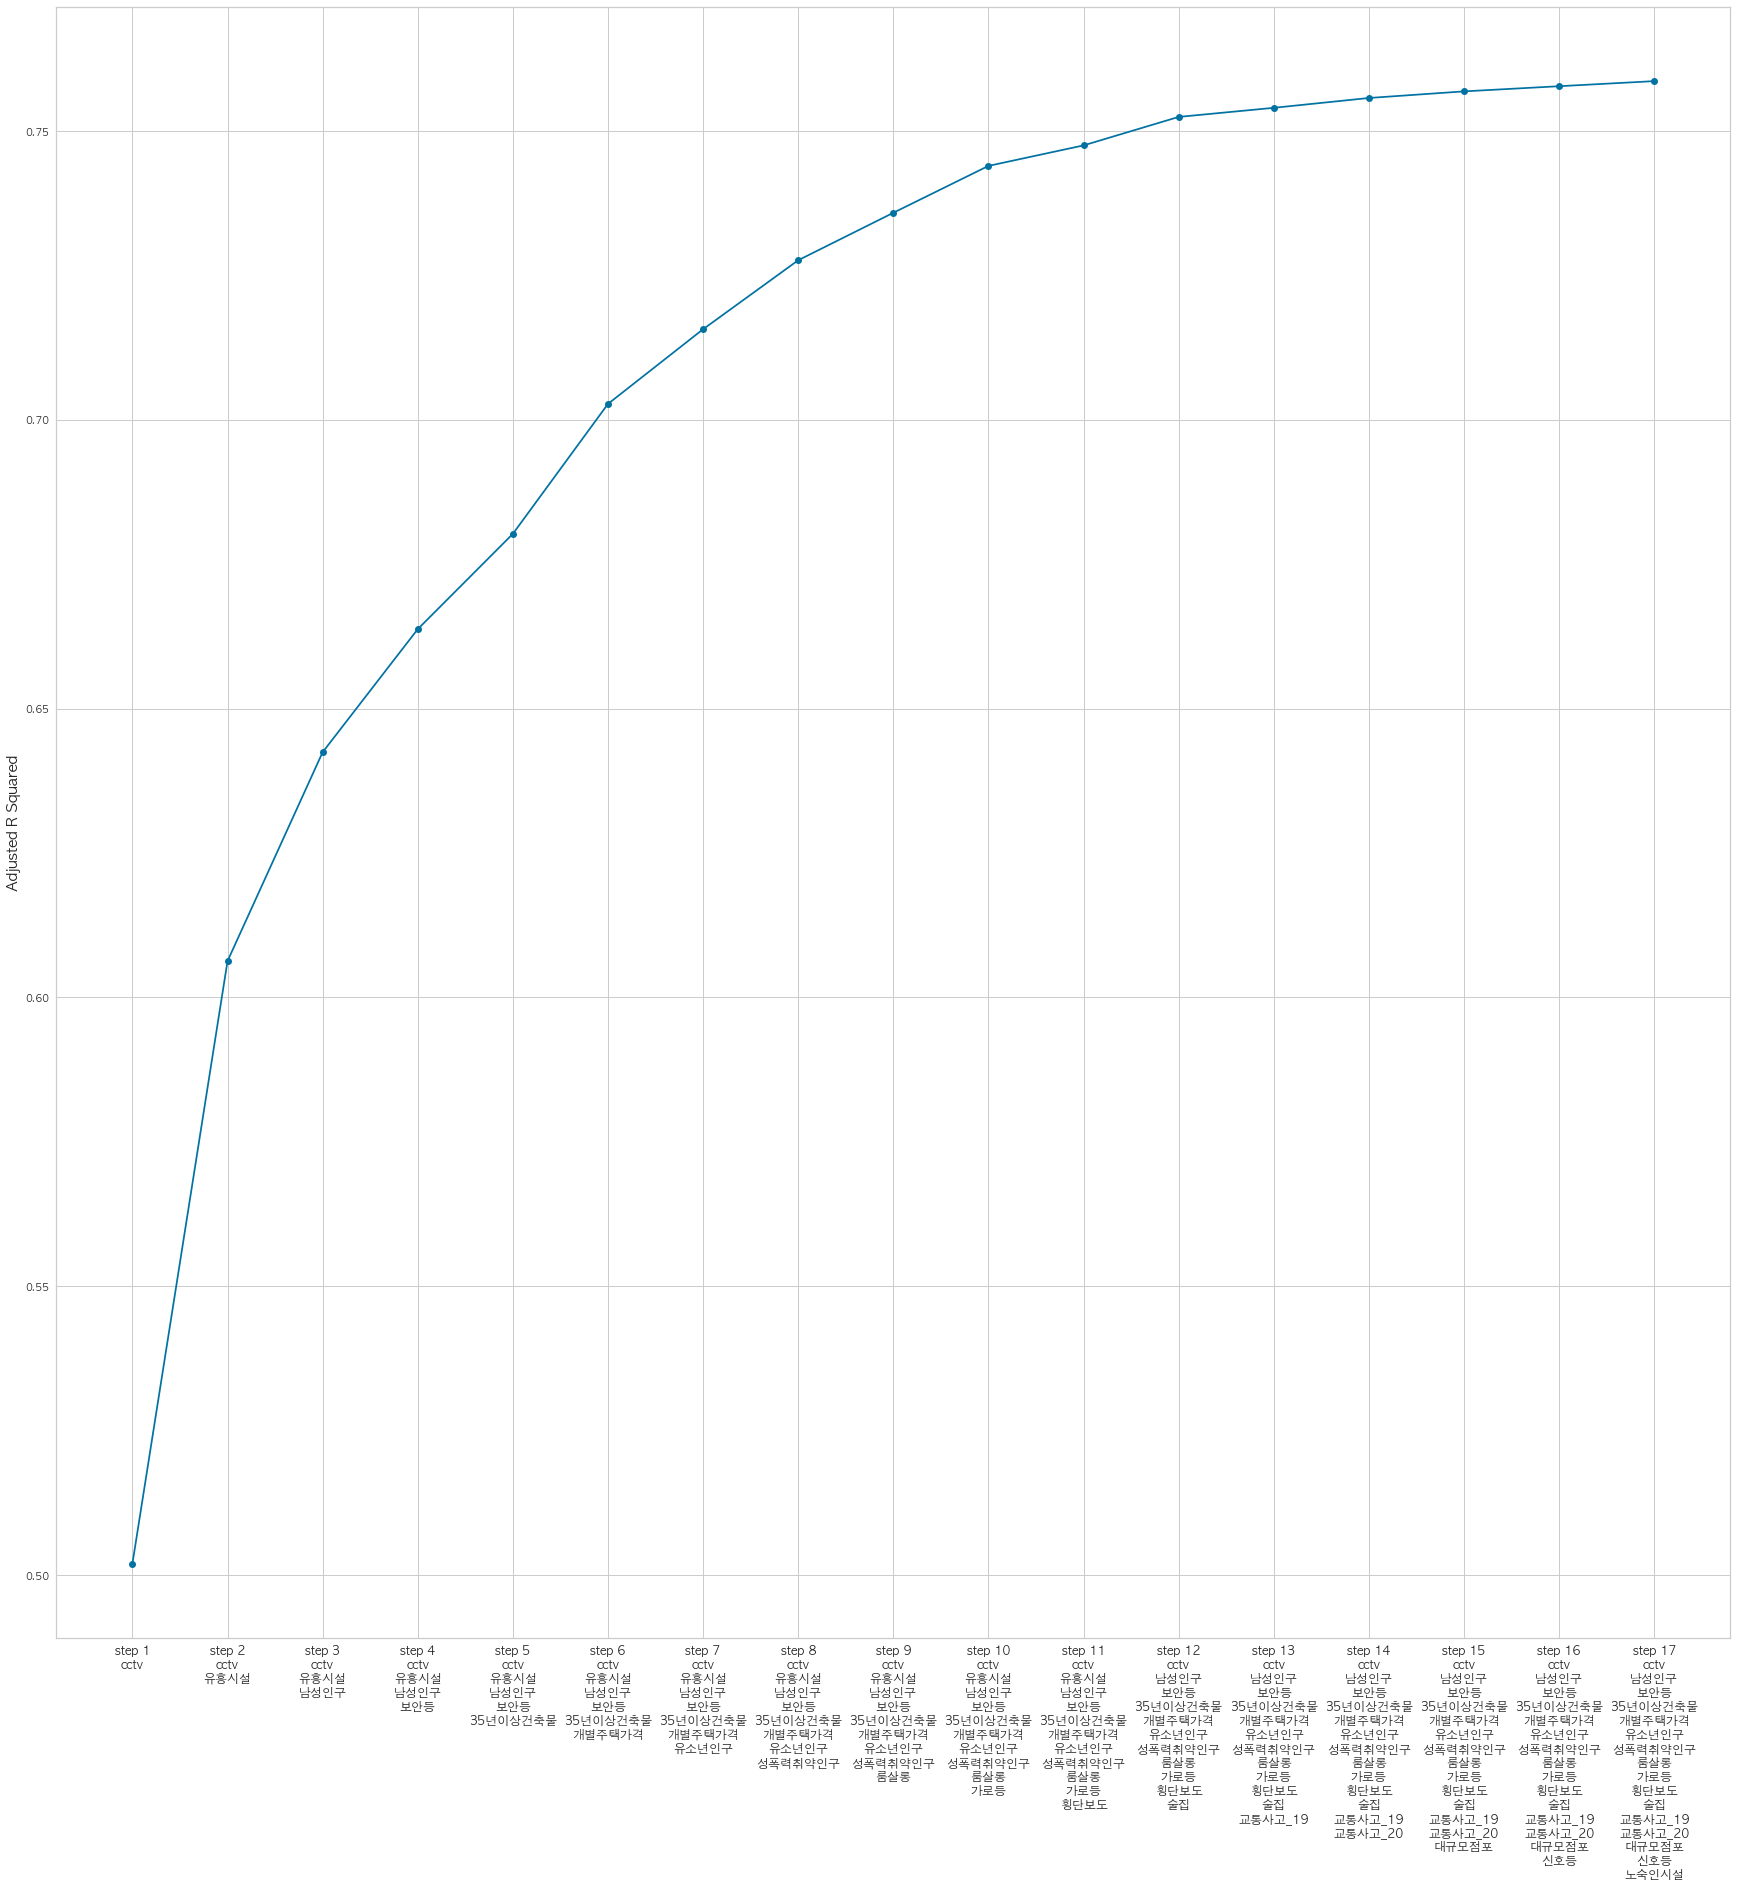

In [110]:
fig = plt.figure(figsize=(30,30))
fig.set_facecolor('white')
 
font_size = 15
plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
plt.plot(steps,adjusted_r_squared, marker='o')
    
plt.ylabel('Adjusted R Squared',fontsize=font_size)
plt.grid(True)
plt.show()

### standardscale

In [111]:
scaler = StandardScaler()
grid_500[numerical_feats] = scaler.fit_transform(grid_500[numerical_feats])

In [112]:
## 전진 단계별 선택법
x_data = grid_500[['총인구', '남성인구', '여성인구', '고등여성인구', '20대여성인구', '유소년인구',
       '고령인구', '30년이상35년미만건축물', '35년이상건축물', '개별주택가격', '공시지가', '가로등',
       '공영주차장', '공중화장실', '교육시설', '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포',
       '대부업현황', '룸살롱', '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집',
       '오락시설', '원룸_오피스텔', '유흥시설', '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도',
       '성폭력취약인구']] #변수 여러개
variables = x_data.columns.tolist() ## 설명 변수 리스트
 
y = grid_500['GRADE_폭력'] ## 반응 변수
selected_variables = [] ## 선택된 변수들
sl_enter = 0.05
sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 
    ## 선형 모형을 적합한다.
    for col in remainder: 
        X = grid_500[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(target,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        ## 선택된 변수들에대해서
        ## 어떤 변수를 제거할지 고른다.
        while len(selected_variables) > 0:
            selected_X = grid_500[selected_variables]
            selected_X = sm.add_constant(selected_X)
            selected_pval = sm.OLS(target,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
            max_pval = selected_pval.max()
            if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                remove_variable = selected_pval.idxmax()
                selected_variables.remove(remove_variable)
            else:
                break
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(target,sm.add_constant(grid_500[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [113]:
selected_variables

['cctv',
 '남성인구',
 '보안등',
 '35년이상건축물',
 '개별주택가격',
 '유소년인구',
 '성폭력취약인구',
 '룸살롱',
 '가로등',
 '횡단보도',
 '술집',
 '교통사고_19',
 '교통사고_20',
 '대규모점포',
 '신호등',
 '노숙인시설']

In [114]:
# 다중 선형회귀분석
x_data = grid_500[selected_variables]
target = grid_500[["GRADE_폭력"]]

# for b0, 상수항 추가
x_data1 = sm.add_constant(x_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(target, x_data1)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               GRADE_폭력   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     181.1
Date:                Wed, 18 Aug 2021   Prob (F-statistic):          3.47e-268
Time:                        15:38:48   Log-Likelihood:                -1296.9
No. Observations:                 918   AIC:                             2628.
Df Residuals:                     901   BIC:                             2710.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1721      0.033     35.403      0.000       1.107       1.237
cctv           0.3147      0.067      4.669      0.000       0.182       0.447
남성인구           2.8698      0.247     11.610      0.000       2.385       3.355
보안등           -0.4934      0.045    -11.013      0.000      -0.581      -0.406
35년이상건축물       0.1910      0.050      3.829      0.000       0.093       0.289
개별주택가격         0.3379      0.045      7.556      0.000       0.250       0.426
유소년인구         -0.9226      0.115     -8.002      0.000      -1.149      -0.696
성폭력취약인구       -1.4316      0.194     -7.395      0.000      -1.812      -1.052
룸살롱            0.1497      0.041      3.615      0.000       0.068       0.231
가로등            0.2644      0.060      4.402      0.000       0.147       0.382
횡단보도           0.2999      0.064      4.697      0.000       0.175       0.425
술집             0.3468      0.052      6.686      0.000       0.245       0.449
교통사고_19        0.2435      0.063      3.849      0.000       0.119       0.368
교통사고_20       -0.0999      0.038     -2.639      0.008      -0.174      -0.026
대규모점포         -0.0916      0.037     -2.482      0.013      -0.164      -0.019
신호등           -0.1340      0.065     -2.071      0.039      -0.261      -0.007
노숙인시설          0.0695      0.034      2.071      0.039       0.004       0.135
==============================================================================
Omnibus:                      326.851   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1548.390
Skew:                           1.585   Prob(JB):                         0.00
Kurtosis:                       8.516   Cond. No.                         25.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [115]:
## 후진 소거법
x_data = grid_500[['총인구', '남성인구', '여성인구', '고등여성인구', '20대여성인구', '유소년인구',
       '고령인구', '30년이상35년미만건축물', '35년이상건축물', '개별주택가격', '공시지가', '가로등',
       '공영주차장', '공중화장실', '교육시설', '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포',
       '대부업현황', '룸살롱', '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집',
       '오락시설', '원룸_오피스텔', '유흥시설', '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도',
       '성폭력취약인구']] #변수 여러개

target = grid_500[["GRADE_폭력"]]

selected_variables = x_data.columns.tolist()

sl_remove = 0.05
 
sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(selected_variables) > 0:
    X = sm.add_constant(grid_500[selected_variables])
    p_vals = sm.OLS(target,X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
    max_pval = p_vals.max() ## 최대 p-value
    if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
        remove_variable = p_vals.idxmax()
        selected_variables.remove(remove_variable)
 
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(target,sm.add_constant(x_data[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [116]:
selected_variables

['총인구',
 '남성인구',
 '유소년인구',
 '35년이상건축물',
 '개별주택가격',
 '가로등',
 '교통사고_19',
 '교통사고_20',
 '노숙인시설',
 '대규모점포',
 '룸살롱',
 '보안등',
 '술집',
 '원룸_오피스텔',
 'cctv',
 '신호등',
 '횡단보도',
 '성폭력취약인구']

In [117]:
# 다중 선형회귀분석
x_data = grid_500[selected_variables]
target = grid_500[["GRADE_폭력"]]

# for b0, 상수항 추가
x_data1 = sm.add_constant(x_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(target, x_data1)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               GRADE_폭력   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     162.6
Date:                Wed, 18 Aug 2021   Prob (F-statistic):          1.01e-267
Time:                        15:38:49   Log-Likelihood:                -1292.6
No. Observations:                 918   AIC:                             2623.
Df Residuals:                     899   BIC:                             2715.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1721      0.033     35.527      0.000       1.107       1.237
총인구           -3.2074      1.280     -2.507      0.012      -5.719      -0.696
남성인구           5.8569      1.255      4.668      0.000       3.394       8.320
유소년인구         -0.9539      0.116     -8.250      0.000      -1.181      -0.727
35년이상건축물       0.1632      0.051      3.223      0.001       0.064       0.263
개별주택가격         0.3380      0.046      7.364      0.000       0.248       0.428
가로등            0.2612      0.060      4.358      0.000       0.144       0.379
교통사고_19        0.2350      0.063      3.721      0.000       0.111       0.359
교통사고_20       -0.0949      0.038     -2.505      0.012      -0.169      -0.021
노숙인시설          0.0699      0.033      2.090      0.037       0.004       0.136
대규모점포         -0.0904      0.037     -2.439      0.015      -0.163      -0.018
룸살롱            0.1447      0.041      3.499      0.000       0.064       0.226
보안등           -0.4584      0.046     -9.902      0.000      -0.549      -0.368
술집             0.3497      0.052      6.719      0.000       0.248       0.452
원룸_오피스텔       -0.1402      0.058     -2.423      0.016      -0.254      -0.027
cctv           0.3482      0.072      4.808      0.000       0.206       0.490
신호등           -0.1283      0.065     -1.985      0.047      -0.255      -0.001
횡단보도           0.2977      0.064      4.677      0.000       0.173       0.423
성폭력취약인구       -1.1309      0.220     -5.140      0.000      -1.563      -0.699
==============================================================================
Omnibus:                      323.991   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1494.525
Skew:                           1.580   Prob(JB):                         0.00
Kurtosis:                       8.394   Cond. No.                         155.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
pca = PCA(n_components=5) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(x_data)
principalDf = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2', 'principal component3', 'principal component4', 'principal component5'])
# 주성분으로 이루어진 데이터 프레임 구성

In [119]:
principalDf.head()


,principal component1,principal component2,principal component3,principal component4,principal component5
0,1.052377,-0.530157,-0.320275,0.218650,0.207479
1,4.622388,1.751507,-2.723114,0.419241,-0.449756
2,-1.353748,0.041094,-0.102616,0.155403,-0.050417
3,4.701432,1.318471,-1.619668,-0.710711,0.430268
4,-1.678959,0.040610,0.006880,0.197316,-0.180520


In [120]:
pca.explained_variance_ratio_

array([0.4561501 , 0.10633806, 0.0663735 , 0.05816465, 0.05610025])

In [121]:
sum(pca.explained_variance_ratio_)

0.7431265581742266

In [122]:
selected_variables

['총인구',
 '남성인구',
 '유소년인구',
 '35년이상건축물',
 '개별주택가격',
 '가로등',
 '교통사고_19',
 '교통사고_20',
 '노숙인시설',
 '대규모점포',
 '룸살롱',
 '보안등',
 '술집',
 '원룸_오피스텔',
 'cctv',
 '신호등',
 '횡단보도',
 '성폭력취약인구']

In [139]:
x_data = grid_500[['총인구',
 '남성인구',
 '유소년인구',
 '35년이상건축물',
 '개별주택가격',
 '가로등',
 '교통사고_19',
 '교통사고_20',
 '노숙인시설',
 '대규모점포',
 '룸살롱',
 '보안등',
 '술집',
 '원룸_오피스텔',
 'cctv',
 '신호등',
 '횡단보도',
 '성폭력취약인구', 'GRADE_폭력']]

### Pycaret

#### 가장 $R^2$가 높았던 변수를 가지고 Pycaret을 이용해 최적의 머신러닝모델 탐색 70% train

In [140]:
x_data

,총인구,남성인구,유소년인구,35년이상건축물,개별주택가격,가로등,교통사고_19,교통사고_20,노숙인시설,대규모점포,룸살롱,보안등,술집,원룸_오피스텔,cctv,신호등,횡단보도,성폭력취약인구,GRADE_폭력
0,0.681072,0.640152,0.421512,-0.278314,0.859172,-0.266892,1.023293,0.167282,-0.05726,-0.151617,-0.115845,0.399775,-0.098374,0.080918,0.542511,-0.502512,-0.431023,0.704448,4
1,1.198744,1.246073,0.630852,4.606423,0.066289,0.458566,0.513036,1.150969,-0.05726,-0.151617,-0.115845,-0.151487,0.081880,1.936357,3.368186,0.346815,2.493043,1.127571,5
2,-0.356230,-0.354523,-0.383283,0.031828,-0.162599,-0.530695,-0.507478,-0.269913,-0.05726,-0.151617,-0.115845,-0.335241,-0.278628,-0.277149,-0.163908,-0.502512,-0.497479,-0.436473,1
3,1.908993,1.987387,0.249389,1.362854,0.604648,0.986172,2.554063,3.009045,-0.05726,-0.151617,-0.115845,2.678322,0.983149,0.862155,0.542511,1.196142,0.167081,0.870675,3
4,-0.466554,-0.471149,-0.383283,-0.317082,-0.823257,-0.530695,-0.337392,-0.269913,-0.05726,-0.151617,-0.115845,-0.298490,-0.278628,-0.309701,-0.517117,-0.502512,-0.497479,-0.436473,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,-0.466554,-0.471149,-0.383283,-0.317082,-0.823257,-0.530695,-0.507478,-0.269913,-0.05726,-0.151617,-0.115845,-0.408742,-0.278628,-0.309701,-0.517117,-0.502512,-0.497479,-0.436473,0
914,-0.466554,-0.471149,-0.383283,-0.317082,-0.823257,-0.530695,-0.507478,-0.269913,-0.05726,-0.151617,-0.115845,-0.408742,-0.278628,-0.309701,-0.517117,-0.502512,-0.497479,-0.436473,0
915,-0.466554,-0.471149,-0.383283,-0.317082,-0.823257,-0.530695,-0.507478,-0.269913,-0.05726,-0.151617,-0.115845,-0.408742,-0.278628,-0.309701,-0.517117,-0.502512,-0.497479,-0.436473,0
916,-0.466554,-0.471149,-0.383283,-0.317082,-0.823257,-0.530695,-0.507478,0.604476,-0.05726,-0.151617,-0.115845,-0.408742,-0.278628,-0.309701,-0.517117,-0.502512,-0.497479,-0.436473,0


In [154]:
x_data.dtypes

총인구         float64
남성인구        float64
유소년인구       float64
35년이상건축물    float64
개별주택가격      float64
가로등         float64
교통사고_19     float64
교통사고_20     float64
노숙인시설       float64
대규모점포       float64
룸살롱         float64
보안등         float64
술집          float64
원룸_오피스텔     float64
cctv        float64
신호등         float64
횡단보도        float64
성폭력취약인구     float64
GRADE_폭력      int64
dtype: object

In [163]:
x_data[['GRADE_폭력']] = x_data[['GRADE_폭력']].astype(float)

In [164]:
reg = setup(x_data, 
            preprocess = False, # True로 설정되면, 자체적인 Feature Engineering을 추가로 진행해 Predict가 불가능해진다.
            train_size = 0.7,  #0.7트레인
            target = "GRADE_폭력", # 목표 변수는 폭력등급이다.
            silent = True, 
            use_gpu = False, 
            numeric_features=list(x_data.drop(columns = ['GRADE_폭력']).columns), # 모든 변수가 숫자로써의 의미가 있다.
            session_id = 2021,
            fold_shuffle = True)

,Description,Value
0,session_id,2021
1,Target,GRADE_폭력
2,Original Data,"(918, 19)"
3,Missing Values,False
4,Numeric Features,18
5,Categorical Features,0
6,Transformed Train Set,"(642, 18)"
7,Transformed Test Set,"(276, 18)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


In [165]:
top5 = compare_models(n_select = 5, sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.5865,1.0524,1.0174,0.7157,0.3789,0.5125,0.0520
rf,Random Forest Regressor,0.5967,1.1045,1.0392,0.7138,0.3951,0.5138,0.2830
catboost,CatBoost Regressor,0.5919,1.1073,1.0396,0.7159,0.3852,0.5165,1.0900
et,Extra Trees Regressor,0.6089,1.1024,1.0434,0.7077,0.4014,0.5091,0.1510
ridge,Ridge Regression,0.6248,1.1345,1.0497,0.7127,0.3859,0.4600,0.0110
br,Bayesian Ridge,0.6319,1.1415,1.0538,0.7108,0.3865,0.4623,0.0140
lr,Linear Regression,0.6221,1.1460,1.0575,0.7084,0.3856,0.4611,0.4940
lar,Least Angle Regression,0.6221,1.1459,1.0575,0.7084,0.3856,0.4611,0.0150
lightgbm,Light Gradient Boosting Machine,0.6111,1.1645,1.0695,0.6900,0.3904,0.5280,0.1660
huber,Huber Regressor,0.5820,1.1951,1.0766,0.7045,0.3783,0.5147,0.0580


#### 전체 변수를 이용한 Pycaret 모델 탐색

In [169]:
x_data = grid_500[['총인구', '남성인구', '여성인구', '고등여성인구', '20대여성인구', '유소년인구',
       '고령인구', '30년이상35년미만건축물', '35년이상건축물', '개별주택가격', '공시지가', '가로등',
       '공영주차장', '공중화장실', '교육시설', '교통사고_19', '교통사고_20', '노숙인시설', '대규모점포',
       '대부업현황', '룸살롱', '버스정류장', '보안등', '상가', '숙박업소', '술집', '어린이보호', '어린이집',
       '오락시설', '원룸_오피스텔', '유흥시설', '음식점', '자율방범대', '파출소', 'cctv', '신호등', '횡단보도',
       '성폭력취약인구','GRADE_폭력']]
x_data[['GRADE_폭력']] = x_data[['GRADE_폭력']].astype(float)

In [170]:
reg = setup(x_data, 
            preprocess = False, # True로 설정되면, 자체적인 Feature Engineering을 추가로 진행해 Predict가 불가능해진다.
            train_size = 0.7,  
            target = "GRADE_폭력", 
            silent = True, 
            use_gpu = False, 
            numeric_features=list(x_data.drop(columns = ['GRADE_폭력']).columns), # 모든 변수가 숫자로써의 의미가 있다.
            session_id = 2021,
            fold_shuffle = True
            )

,Description,Value
0,session_id,2021
1,Target,GRADE_폭력
2,Original Data,"(918, 39)"
3,Missing Values,False
4,Numeric Features,38
5,Categorical Features,0
6,Transformed Train Set,"(642, 38)"
7,Transformed Test Set,"(276, 38)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


In [171]:
top5 = compare_models(n_select = 5, sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.5584,0.9939,0.9855,0.7466,0.3595,0.4966,0.0760
rf,Random Forest Regressor,0.5824,1.0879,1.0328,0.7202,0.3823,0.5025,0.2230
catboost,CatBoost Regressor,0.5851,1.0982,1.0336,0.7256,0.3794,0.4940,2.8860
et,Extra Trees Regressor,0.5903,1.0838,1.0349,0.7145,0.3911,0.5024,0.1720
lightgbm,Light Gradient Boosting Machine,0.6043,1.1327,1.0558,0.7079,0.3844,0.5167,0.2560
xgboost,Extreme Gradient Boosting,0.6071,1.1833,1.0799,0.6859,0.3927,0.5382,0.6360
knn,K Neighbors Regressor,0.6001,1.2279,1.0939,0.6893,0.3835,0.5136,0.0150
br,Bayesian Ridge,0.6719,1.2530,1.1052,0.6848,0.3877,0.4784,0.0130
ridge,Ridge Regression,0.6648,1.2900,1.1213,0.6764,0.3934,0.4846,0.0180
lr,Linear Regression,0.6663,1.3137,1.1347,0.6674,0.3963,0.4888,0.8260


In [172]:
gbr = create_model('gbr', cross_validation = False)
rf = create_model('rf', cross_validation = False)
cat = create_model('catboost', cross_validation = False)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.585,1.0261,1.0129,0.7504,0.3399,0.5034


In [173]:
# 하이퍼파라미터 튜닝
tuned_gbr = tune_model(gbr, optimize = 'RMSE', n_iter = 10)
tuned_rf = tune_model(rf, optimize = 'RMSE', n_iter = 10)
tuned_cat = tune_model(cat, optimize = 'RMSE', n_iter = 10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.5438,1.2129,1.1013,0.6105,0.3630,0.3987
1,0.4859,0.7625,0.8732,0.7407,0.3032,0.5296
2,0.6688,1.1195,1.0581,0.7254,0.3916,0.6045
3,0.4672,0.7027,0.8383,0.8264,0.3034,0.4969
4,0.7340,1.3884,1.1783,0.7514,0.3987,0.4750
5,0.5438,0.8002,0.8946,0.8645,0.3437,0.4157
6,0.3683,0.4538,0.6736,0.6973,0.2947,0.4553
7,0.6578,1.4413,1.2006,0.6953,0.3949,0.4276
8,0.6187,1.2826,1.1325,0.6796,0.3801,0.5828
9,0.6005,1.1278,1.0620,0.7878,0.3486,0.3906


In [174]:
# 모델 블렌딩(Blend)

blender_specific = blend_models(estimator_list = [tuned_gbr,tuned_rf,tuned_cat], optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.5297,1.0326,1.0161,0.6684,0.3513,0.4495
1,0.4949,0.8749,0.9354,0.7025,0.3256,0.5407
2,0.6566,1.1359,1.0658,0.7214,0.3974,0.5952
3,0.4585,0.6261,0.7913,0.8453,0.2990,0.5116
4,0.6915,1.3069,1.1432,0.7660,0.3769,0.4816
5,0.5510,0.9253,0.9619,0.8433,0.3397,0.4117
6,0.3728,0.4434,0.6659,0.7042,0.2900,0.5227
7,0.5886,1.1753,1.0841,0.7515,0.3770,0.4239
8,0.6170,1.4000,1.1832,0.6503,0.3998,0.6230
9,0.5740,1.0182,1.0090,0.8084,0.3437,0.3662


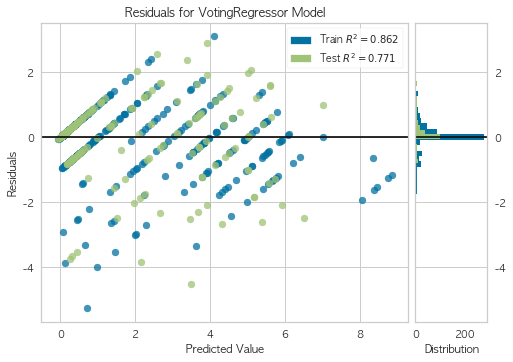

In [175]:
# 모델 시각화(plot)_plot = 'residuals'

plot_model(blender_specific)

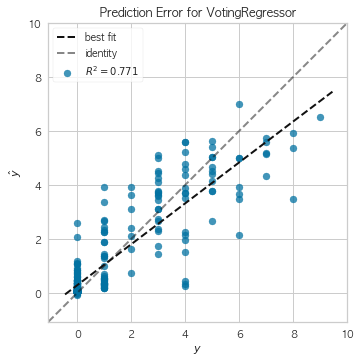

In [176]:

# 모델 시각화(plot)_plot = 'error'

plot_model(blender_specific, plot='error')

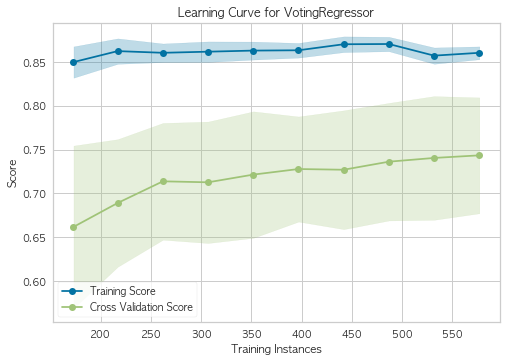

In [177]:
# 모델 시각화(plot)_plot = 'learning'

plot_model(blender_specific, plot='learning')

#### 80%의 트레인셋으로 모델 적합

In [183]:
reg = setup(x_data, 
            preprocess = False, # True로 설정되면, 자체적인 Feature Engineering을 추가로 진행해 Predict가 불가능해진다.
            train_size = 0.9,  
            target = "GRADE_폭력", 
            silent = True, 
            use_gpu = False, 
            numeric_features=list(x_data.drop(columns = ['GRADE_폭력']).columns), # 모든 변수가 숫자로써의 의미가 있다.
            session_id = 2021,
            fold_shuffle = False
            )

,Description,Value
0,session_id,2021
1,Target,GRADE_폭력
2,Original Data,"(918, 39)"
3,Missing Values,False
4,Numeric Features,38
5,Categorical Features,0
6,Transformed Train Set,"(826, 38)"
7,Transformed Test Set,"(92, 38)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


In [184]:
top5 = compare_models(n_select = 5, sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.5600,1.0300,1.0035,0.7443,0.3690,0.5198,0.4070
gbr,Gradient Boosting Regressor,0.5661,1.0507,1.0108,0.7381,0.3577,0.5182,0.1660
et,Extra Trees Regressor,0.5725,1.0559,1.0155,0.7365,0.3786,0.5190,0.3730
catboost,CatBoost Regressor,0.5672,1.0707,1.0222,0.7341,0.3646,0.5163,2.4050
lightgbm,Light Gradient Boosting Machine,0.5992,1.1605,1.0617,0.7138,0.3843,0.5284,0.4330
br,Bayesian Ridge,0.6511,1.1786,1.0676,0.7122,0.3767,0.4759,0.0100
ridge,Ridge Regression,0.6383,1.1826,1.0676,0.7126,0.3770,0.4774,0.0080
xgboost,Extreme Gradient Boosting,0.5850,1.1730,1.0721,0.7038,0.3825,0.5720,0.8470
lr,Linear Regression,0.6384,1.1954,1.0728,0.7096,0.3769,0.4795,0.5480
knn,K Neighbors Regressor,0.5921,1.2489,1.1008,0.6938,0.3790,0.5036,0.0160


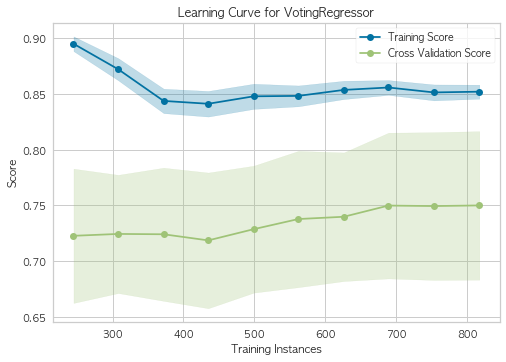

In [182]:
# 모델 시각화(plot)_plot = 'learning'

plot_model(blender_specific, plot='learning')